<a href="https://colab.research.google.com/github/alenabozny/context-augmentation/blob/master/LIWC_LR_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mount Google Drive to the Notebook. This allows us to load datasets that are copyied to the GD directory.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle

## **Load the dataset (LIWC features for CRED/NONCRED data)**

In [ ]:
import pandas as pd
import numpy as np

statins = pd.read_csv("/content/drive/My Drive/Colab Notebooks/LIWC_paragrafy.csv", sep=";",decimal=',', header=0)
psychiatry = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/psychiatry.csv", sep=";",decimal=',', header=0)
antioxidants = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/antioxidants.csv", sep=";",decimal=',', header=0)
ssri_during_pregnancy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/ssri_during_pregnancy.csv", sep=";",decimal=',', header=0)
cc_vs_nb = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/cc_vs_nb.csv", sep=";",decimal=',', header=0)
aspirin_pregnancy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/aspirin_pregnancy.csv", sep=";",decimal=',', header=0)
children_antibiotics = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/children_antibiotics.csv", sep=";",decimal=',', header=0)
allergy_testing = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/allergy_testing.csv", sep=";",decimal=',', header=0)
diet_and_autism = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/diet_and_autism.csv", sep=";",decimal=',', header=0)
heart_supplements = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/heart_supplements.csv", sep=";",decimal=',', header=0)
ssri_during_pregnancy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/ssri_during_pregnancy.csv", sep=";",decimal=',', header=0)
steroids_for_kids = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/steroids_for_kids.csv", sep=";",decimal=',', header=0)
vaccination = pd.read_csv("/content/drive/My Drive/Colab Notebooks/paragrafy_LIWC/vaccination.csv", sep=";",decimal=',', header=0)

statins['Body'].head()

## Non-overlapping paragraphs

In [230]:
statins_paragraphs = statins[0:1917:3]
psychiatry_paragraphs = psychiatry[0:len(psychiatry):3]
antioxidants_paragraphs = antioxidants[0:len(antioxidants):3]
ssri_during_pregnancy_paragraphs = ssri_during_pregnancy[0:len(ssri_during_pregnancy):3]
cc_vs_nb_paragraphs = cc_vs_nb[0:len(cc_vs_nb):3]
aspirin_pregnancy_paragraphs = aspirin_pregnancy[0:len(aspirin_pregnancy):3]
children_antibiotics_paragraphs = children_antibiotics[0:len(children_antibiotics):3]
allergy_testing_paragraphs = allergy_testing[0:len(allergy_testing):3]
diet_and_autism_paragraphs = diet_and_autism[0:len(diet_and_autism):3]
heart_supplements_paragraphs = heart_supplements[0:len(heart_supplements):3]
steroids_for_kids_paragraphs = steroids_for_kids[0:len(steroids_for_kids):3]
vaccination_paragraphs = vaccination[0:len(vaccination):3]

## Overlapping paragraphs

In [ ]:
statins_paragraphs = statins
psychiatry_paragraphs = psychiatry
antioxidants_paragraphs = antioxidants
ssri_during_pregnancy_paragraphs = ssri_during_pregnancy
cc_vs_nb_paragraphs = cc_vs_nb
aspirin_pregnancy_paragraphs = aspirin_pregnancy
children_antibiotics_paragraphs = children_antibiotics
allergy_testing_paragraphs = allergy_testing
diet_and_autism_paragraphs = diet_and_autism
heart_supplements_paragraphs = heart_supplements
steroids_for_kids_paragraphs = steroids_for_kids
vaccination_paragraphs = vaccination

In [ ]:
ssri_during_pregnancy_paragraphs.head()

In [231]:
def y_to_binary(Y):
  def label_to_0_1(lbl):
    if lbl=='CRED':
      return 1
    else:
      return 0

  Y_mapped = map(label_to_0_1, Y)
  return np.array(list(Y_mapped))

In [ ]:
np.shape(ssri_during_pregnancy_paragraphs)

In [ ]:
!pip install spacytextblob

In [ ]:
!pip install lime

# The Model
Features:
- TFIDF
- NER
- POS
- LIWC
- sentiment

In [232]:
from sklearn.pipeline import Pipeline
# from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing as p
from collections import Counter
import matplotlib.pyplot as plt


def get_y(data, y_column = 'Source (B)'):
  Y = data[y_column]
  Y = y_to_binary(Y)
  print(np.shape(Y))
  return Y

statins_Y = get_y(statins_paragraphs, y_column='Rate')
psychiatry_Y = get_y(psychiatry_paragraphs)
antioxidants_Y = get_y(antioxidants_paragraphs)
cc_vs_nb_Y = get_y(cc_vs_nb_paragraphs)
aspirin_pregnancy_Y = get_y(aspirin_pregnancy_paragraphs)
children_antibiotics_Y = get_y(children_antibiotics_paragraphs)
allergy_testing_Y = get_y(allergy_testing_paragraphs)
diet_and_autism_Y = get_y(diet_and_autism_paragraphs)
heart_supplements_Y = get_y(heart_supplements_paragraphs)
ssri_during_pregnancy_Y = get_y(ssri_during_pregnancy_paragraphs)
steroids_for_kids_Y = get_y(steroids_for_kids_paragraphs)
vaccination_Y = get_y(vaccination_paragraphs)

(639,)
(807,)
(225,)
(171,)
(109,)
(185,)
(451,)
(182,)
(150,)
(58,)
(241,)
(482,)


### **TFIDF**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk

nltk.download('punkt')

from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize

def get_X_tfidf(data, body_column='Source (A)'):
  corpus = data[body_column]
  corpus_removed_numbers = [re.sub(r'\d+', '', s) for s in corpus]

  corpus_tokenized = []
  stemmer= PorterStemmer()

  for s in corpus_removed_numbers:
    tokens = word_tokenize(s)
    stemmed_tokens = [stemmer.stem(word.lower()) for word in tokens]
    corpus_tokenized.append(" ".join(stemmed_tokens))

  vectorizer = TfidfVectorizer()
  X_tfidf_array = vectorizer.fit_transform(corpus_tokenized)
  X_tfidf_array = np.array(X_tfidf_array.toarray())
  X_tfidf = pd.DataFrame(X_tfidf_array, columns=vectorizer.get_feature_names())
  print(np.shape(X_tfidf))

  return X_tfidf

In [ ]:
statins_X_tfidf = get_X_tfidf(statins_paragraphs, body_column='Body')
psychiatry_X_tfidf = get_X_tfidf(psychiatry_paragraphs)
antioxidants_X_tfidf = get_X_tfidf(antioxidants_paragraphs)
cc_vs_nb_X_tfidf = get_X_tfidf(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_tfidf = get_X_tfidf(aspirin_pregnancy_paragraphs)
children_antibiotics_X_tfidf = get_X_tfidf(children_antibiotics_paragraphs)
allergy_testing_X_tfidf = get_X_tfidf(allergy_testing_paragraphs)
diet_and_autism_X_tfidf = get_X_tfidf(diet_and_autism_paragraphs)
heart_supplements_X_tfidf = get_X_tfidf(heart_supplements_paragraphs)
ssri_during_pregnancy_X_tfidf = get_X_tfidf(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_tfidf = get_X_tfidf(steroids_for_kids_paragraphs)
vaccination_X_tfidf = get_X_tfidf(vaccination_paragraphs)

In [ ]:
ssri_during_pregnancy_X_tfidf.head()

##**NER**

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = spacy.load("en_core_web_sm")

def get_X_ner(data, body_column='Source (A)'):
  corpus = data[body_column]
  X_ner_counters = []
  X_ner_array = []
  meta_counter = Counter()

  for s in corpus:
    doc = nlp(s)
    labels = [x.label_ for x in doc.ents]
    X_ner_counters.append(Counter(labels))
    meta_counter += Counter(labels)

  for c in X_ner_counters:
    X_ner_array.append([c[key] for key in list(meta_counter.keys())])

  X_ner = pd.DataFrame(X_ner_array, columns=list(meta_counter.keys()))
  X_ner.rename(columns=lambda x: x+"_NER", inplace=True)
  print(np.shape(X_ner))
  
  return X_ner

In [ ]:
statins_X_ner = get_X_ner(statins_paragraphs, body_column='Body')
psychiatry_X_ner = get_X_ner(psychiatry_paragraphs)
antioxidants_X_ner = get_X_ner(antioxidants_paragraphs)
cc_vs_nb_X_ner = get_X_ner(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_ner = get_X_ner(aspirin_pregnancy_paragraphs)
children_antibiotics_X_ner = get_X_ner(children_antibiotics_paragraphs)
allergy_testing_X_ner = get_X_ner(allergy_testing_paragraphs)
diet_and_autism_X_ner = get_X_ner(diet_and_autism_paragraphs)
heart_supplements_X_ner = get_X_ner(heart_supplements_paragraphs)
ssri_during_pregnancy_X_ner = get_X_ner(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_ner = get_X_ner(steroids_for_kids_paragraphs)
vaccination_X_ner = get_X_ner(vaccination_paragraphs)

ssri_during_pregnancy_X_ner.head()

## **LIWC**

In [ ]:
# important_features = get_n_most_important(50)
def get_X_liwc(data):
  X_liwc = data.loc[:,'WC':]
  X_liwc = X_liwc.reset_index(drop=True)
  print(np.shape(X_liwc))
  
  X_liwc.rename(columns=lambda x: x+"_liwc", inplace=True)
  
  return X_liwc

In [ ]:
statins_X_liwc = get_X_liwc(statins_paragraphs)
psychiatry_X_liwc = get_X_liwc(psychiatry_paragraphs)
antioxidants_X_liwc = get_X_liwc(antioxidants_paragraphs)
cc_vs_nb_X_liwc = get_X_liwc(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_liwc = get_X_liwc(aspirin_pregnancy_paragraphs)
children_antibiotics_X_liwc = get_X_liwc(children_antibiotics_paragraphs)
allergy_testing_X_liwc = get_X_liwc(allergy_testing_paragraphs)
diet_and_autism_X_liwc = get_X_liwc(diet_and_autism_paragraphs)
heart_supplements_X_liwc = get_X_liwc(heart_supplements_paragraphs)
ssri_during_pregnancy_X_liwc = get_X_liwc(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_liwc = get_X_liwc(steroids_for_kids_paragraphs)
vaccination_X_liwc = get_X_liwc(vaccination_paragraphs)

ssri_during_pregnancy_X_liwc.head()

## **Sentiment**

In [ ]:
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe('spacytextblob')

In [ ]:
def get_X_sentiment(data, body_column='Source (A)'):
  corpus = data[body_column]
  X_sentiment_array = []
  for s in corpus:
    doc = nlp(s)
    # print(f"Polarity: {doc._.polarity}")
    # print(f"Subjectivity: {doc._.subjectivity}")
    X_sentiment_array.append([doc._.polarity,
                              doc._.subjectivity]
                            )
    
  X_sentiment = pd.DataFrame(X_sentiment_array, columns=["polarity_sent", "subjectivity_sent"])
  print(np.shape(X_sentiment))
  
  return X_sentiment

In [ ]:
statins_X_sentiment = get_X_sentiment(statins_paragraphs, body_column='Body')
psychiatry_X_sentiment = get_X_sentiment(psychiatry_paragraphs)
antioxidants_X_sentiment = get_X_sentiment(antioxidants_paragraphs)
cc_vs_nb_X_sentiment = get_X_sentiment(cc_vs_nb_paragraphs)
aspirin_pregnancy_X_sentiment = get_X_sentiment(aspirin_pregnancy_paragraphs)
children_antibiotics_X_sentiment = get_X_sentiment(children_antibiotics_paragraphs)
allergy_testing_X_sentiment = get_X_sentiment(allergy_testing_paragraphs)
diet_and_autism_X_sentiment = get_X_sentiment(diet_and_autism_paragraphs)
heart_supplements_X_sentiment = get_X_sentiment(heart_supplements_paragraphs)
ssri_during_pregnancy_X_sentiment = get_X_sentiment(ssri_during_pregnancy_paragraphs)
steroids_for_kids_X_sentiment = get_X_sentiment(steroids_for_kids_paragraphs)
vaccination_X_sentiment = get_X_sentiment(vaccination_paragraphs)

vaccination_X_sentiment.head()

In [ ]:
# X = pd.concat([X_liwc, X_ner, X_tfidf, X_sentiment], axis=1)
statins_X = pd.concat([statins_X_liwc, statins_X_ner, statins_X_tfidf, statins_X_sentiment], axis=1)
psychiatry_X = pd.concat([psychiatry_X_liwc, psychiatry_X_ner, psychiatry_X_tfidf, psychiatry_X_sentiment], axis=1)
antioxidants_X = pd.concat([antioxidants_X_liwc, antioxidants_X_ner, antioxidants_X_tfidf, antioxidants_X_sentiment], axis=1)
cc_vs_nb_X = pd.concat([cc_vs_nb_X_liwc, cc_vs_nb_X_ner, cc_vs_nb_X_tfidf, cc_vs_nb_X_sentiment], axis=1)
aspirin_pregnancy_X = pd.concat([aspirin_pregnancy_X_liwc, aspirin_pregnancy_X_ner, aspirin_pregnancy_X_tfidf, aspirin_pregnancy_X_sentiment], axis=1)
children_antibiotics_X = pd.concat([children_antibiotics_X_liwc, children_antibiotics_X_ner, children_antibiotics_X_tfidf, children_antibiotics_X_sentiment], axis=1)
allergy_testing_X = pd.concat([allergy_testing_X_liwc, allergy_testing_X_ner, allergy_testing_X_tfidf, allergy_testing_X_sentiment], axis=1)
diet_and_autism_X = pd.concat([diet_and_autism_X_liwc, diet_and_autism_X_ner, diet_and_autism_X_tfidf, diet_and_autism_X_sentiment], axis=1)
heart_supplements_X = pd.concat([heart_supplements_X_liwc, heart_supplements_X_ner, heart_supplements_X_tfidf, heart_supplements_X_sentiment], axis=1)
ssri_during_pregnancy_X = pd.concat([ssri_during_pregnancy_X_liwc, ssri_during_pregnancy_X_ner, ssri_during_pregnancy_X_tfidf, ssri_during_pregnancy_X_sentiment], axis=1)
steroids_for_kids_X = pd.concat([steroids_for_kids_X_liwc, steroids_for_kids_X_ner, steroids_for_kids_X_tfidf, steroids_for_kids_X_sentiment], axis=1)
vaccination_X = pd.concat([vaccination_X_liwc, vaccination_X_ner, vaccination_X_tfidf, vaccination_X_sentiment], axis=1)

In [ ]:
ssri_during_pregnancy_X.head()

## Dump ***TFIDF + NER + LIWC + Sentiment*** X data

In [ ]:
pickle.dump(statins_X, open('/content/drive/My Drive/Colab Notebooks/statins_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(psychiatry_X, open('/content/drive/My Drive/Colab Notebooks/psychiatry_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(antioxidants_X, open('/content/drive/My Drive/Colab Notebooks/antioxidants_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(cc_vs_nb_X, open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(aspirin_pregnancy_X, open('/content/drive/My Drive/Colab Notebooks/aspirin_pregnancy_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(children_antibiotics_X, open('/content/drive/My Drive/Colab Notebooks/children_antibiotics_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(allergy_testing_X, open('/content/drive/My Drive/Colab Notebooks/allergy_testing_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(diet_and_autism_X, open('/content/drive/My Drive/Colab Notebooks/diet_and_autism_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(heart_supplements_X, open('/content/drive/My Drive/Colab Notebooks/heart_supplements_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(ssri_during_pregnancy_X, open('/content/drive/My Drive/Colab Notebooks/ssri_during_pregnancy_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(steroids_for_kids_X, open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_tfidf_ner_liwc_sent_X.p', 'wb'))
pickle.dump(vaccination_X, open('/content/drive/My Drive/Colab Notebooks/vaccination_tfidf_ner_liwc_sent_X.p', 'wb'))

In [ ]:
# dump overlapping paragraphs
pickle.dump(statins_X, open('/content/drive/My Drive/Colab Notebooks/statins_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(psychiatry_X, open('/content/drive/My Drive/Colab Notebooks/psychiatry_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(antioxidants_X, open('/content/drive/My Drive/Colab Notebooks/antioxidants_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(cc_vs_nb_X, open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(aspirin_pregnancy_X, open('/content/drive/My Drive/Colab Notebooks/aspirin_pregnancy_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(children_antibiotics_X, open('/content/drive/My Drive/Colab Notebooks/children_antibiotics_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(allergy_testing_X, open('/content/drive/My Drive/Colab Notebooks/allergy_testing_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(diet_and_autism_X, open('/content/drive/My Drive/Colab Notebooks/diet_and_autism_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(heart_supplements_X, open('/content/drive/My Drive/Colab Notebooks/heart_supplements_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(ssri_during_pregnancy_X, open('/content/drive/My Drive/Colab Notebooks/ssri_during_pregnancy_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(steroids_for_kids_X, open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))
pickle.dump(vaccination_X, open('/content/drive/My Drive/Colab Notebooks/vaccination_tfidf_ner_liwc_sent_X_overlap.p', 'wb'))

## Load ***TFIDF + NER + LIWC + Sentiment*** X data

In [ ]:
statins_X =               pickle.load(open('/content/drive/My Drive/Colab Notebooks/statins_tfidf_ner_liwc_sent_X.p', 'rb'))
psychiatry_X =            pickle.load(open('/content/drive/My Drive/Colab Notebooks/psychiatry_tfidf_ner_liwc_sent_X.p', 'rb'))
antioxidants_X =          pickle.load(open('/content/drive/My Drive/Colab Notebooks/antioxidants_tfidf_ner_liwc_sent_X.p', 'rb'))
cc_vs_nb_X =              pickle.load(open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_tfidf_ner_liwc_sent_X.p', 'rb'))
aspirin_pregnancy_X =     pickle.load(open('/content/drive/My Drive/Colab Notebooks/aspirin_pregnancy_tfidf_ner_liwc_sent_X.p', 'rb'))
children_antibiotics_X =  pickle.load(open('/content/drive/My Drive/Colab Notebooks/children_antibiotics_tfidf_ner_liwc_sent_X.p', 'rb'))
allergy_testing_X =       pickle.load(open('/content/drive/My Drive/Colab Notebooks/allergy_testing_tfidf_ner_liwc_sent_X.p', 'rb'))
diet_and_autism_X =       pickle.load(open('/content/drive/My Drive/Colab Notebooks/diet_and_autism_tfidf_ner_liwc_sent_X.p', 'rb'))
heart_supplements_X =     pickle.load(open('/content/drive/My Drive/Colab Notebooks/heart_supplements_tfidf_ner_liwc_sent_X.p', 'rb'))
ssri_during_pregnancy_X = pickle.load(open('/content/drive/My Drive/Colab Notebooks/ssri_during_pregnancy_tfidf_ner_liwc_sent_X.p', 'rb'))
steroids_for_kids_X =     pickle.load(open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_tfidf_ner_liwc_sent_X.p', 'rb'))
vaccination_X =           pickle.load(open('/content/drive/My Drive/Colab Notebooks/vaccination_tfidf_ner_liwc_sent_X.p', 'rb'))

In [ ]:
statins_X_overlap =               pickle.load(open('/content/drive/My Drive/Colab Notebooks/statins_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
psychiatry_X_overlap =            pickle.load(open('/content/drive/My Drive/Colab Notebooks/psychiatry_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
antioxidants_X_overlap =          pickle.load(open('/content/drive/My Drive/Colab Notebooks/antioxidants_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
cc_vs_nb_X_overlap =              pickle.load(open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
aspirin_pregnancy_X_overlap =     pickle.load(open('/content/drive/My Drive/Colab Notebooks/aspirin_pregnancy_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
children_antibiotics_X_overlap =  pickle.load(open('/content/drive/My Drive/Colab Notebooks/children_antibiotics_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
allergy_testing_X_overlap =       pickle.load(open('/content/drive/My Drive/Colab Notebooks/allergy_testing_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
diet_and_autism_X_overlap =       pickle.load(open('/content/drive/My Drive/Colab Notebooks/diet_and_autism_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
heart_supplements_X_overlap =     pickle.load(open('/content/drive/My Drive/Colab Notebooks/heart_supplements_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
ssri_during_pregnancy_X_overlap = pickle.load(open('/content/drive/My Drive/Colab Notebooks/ssri_during_pregnancy_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
steroids_for_kids_X_overlap =     pickle.load(open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))
vaccination_X_overlap =           pickle.load(open('/content/drive/My Drive/Colab Notebooks/vaccination_tfidf_ner_liwc_sent_X_overlap.p', 'rb'))

Check the data:

In [ ]:
np.shape(vaccination_X)

In [ ]:
np.shape(vaccination_X_overlap)

# Eval and print metrics

## For each category we are preforming the following steps:
1. **Feature selection** based on **LogisticRegression** and **Recursive Feature Elimination** algorithm
2. Perform **best model selection** based on genetic algorithm implemented by the TPOT library (we combine LogisticRegression, GBoost, MLP(50,20) and MLP(20,20). We use **weighted f1** measure as **optimization attribute**.
3. **ROC curve** is shown for the **result of TPOT best fitted model**, with max/min and mean curves from 10-fold cross validation.
4. **Mean weighted f1 for 30 Cross Validated scores** with standard deviation is shown. 

## Paragraph label aggregation:


```
def aggregate_rate(rate_list):
    if 'NONCRED' in rate_list:
        return 'NONCRED'
    elif 'CRED' in rate_list:
        return 'CRED'
    else:
        return 'NEU'
```
- NONCRED - if one or more labels is rated not credible
- CRED - if no non-credible sentences and at least one credible sentence appears in the set.
- NEU - if all 3 sentences are neutral.

Binary labelling function further compress the labels to:
* **1** - CRED
* **0** - NONCRED or NEU


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import sklearn.preprocessing as p

min_max_scaler = p.MinMaxScaler()
standard_scaler = p.StandardScaler()

class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def eval_and_print_metrics(clf, X, Y, VALIDATION_SPLIT):
    scaled_features = standard_scaler.fit_transform(X)
    scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT, stratify=Y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print("F1 score on test set: "
          # "%0.3f" % metrics.f1_score(y_test, y_pred, average='weighted'))
    # print("-" * 10)
    return metrics.f1_score(y_test, y_pred, average='weighted'), metrics.f1_score(y_test, y_pred, average='micro')

def mean_weighted_f1(clf, X, Y, num_iterations, VALIDATION_SPLIT):
  f1s_w = []
  f1s_m = []
  scaled_features = standard_scaler.fit_transform(X)
  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  for i in range(0,num_iterations):
    w, m = eval_and_print_metrics(clf, X, Y, VALIDATION_SPLIT)
    f1s_w.append(w)
    f1s_m.append(m)

  print(color.BOLD + 'Mean weighted f1: ' + color.END, np.mean(f1s_w), color.BOLD + ' STD: ' + color.END, np.std(f1s_w))
  print(color.BOLD + 'Mean micro f1: ' + color.END , np.mean(f1s_m), color.BOLD + ' STD: ' + color.END, np.std(f1s_m))

# Fit and show AUC

##**RFE**

Recursive feature elimination using **Logistic Regression** model and **f1_weighted** score as an optimization parameter.

**Variant A:** *A the end of the function there is a limit of most **num_limit** features.*


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

def get_n_most_important(num_features, 
                         X, 
                         Y, 
                         standarize=True, 
                         scorer='f1_weighted', 
                         model = LogisticRegression(max_iter=10000)
                        ):
  if standarize:
    scaled_features = standard_scaler.fit_transform(X)
    X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

  rfecv = RFECV(estimator=model, step=10, cv=StratifiedKFold(),
                scoring=scorer,
                min_features_to_select=num_features)
  fit = rfecv.fit(X, Y)

  print("Optimal number of features : %d" % rfecv.n_features_)

  # Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(num_features,
                len(rfecv.grid_scores_) + num_features),
          rfecv.grid_scores_)
  plt.show()
  
  features = X.columns.values
  important_features = []

  for f in list(zip(features, fit.support_)):
    if f[1]:
      important_features.append(f[0])

  return fit.support_, fit.n_features_, fit.ranking_, important_features

## Show mean, min and max ROC curves for N-fold cross validation

In [ ]:
def show_auc_for_cv(classifier, X, y, n_splits=10, split=0.2):

  from sklearn.metrics import plot_roc_curve
  from sklearn.metrics import auc

  scaled_features = standard_scaler.fit_transform(X)
  X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

  X = np.array(X)
  y = np.array(y)

  cv = StratifiedKFold(n_splits=10)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = plot_roc_curve(classifier, X[test], y[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example")
  ax.legend(loc="lower right")
  plt.legend(bbox_to_anchor=(1,1), loc="upper left")
  plt.show()

## Show predicted probabilities for each class and print top most important features

In [ ]:
def predict_proba_hist(clf, X, Y, important_features, split=0.2, idx=1):
  scaled_X = standard_scaler.fit_transform(X[important_features])
  X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                      Y, 
                                                      test_size=split, 
                                                      stratify=Y)
  clf.fit(X_train, y_train)
  proba_1 = {}
  proba_0 = {}

  print(f"Model: {clf}")
  try:
    coefs = clf.feature_importances_
  except AttributeError:
    try:
      coefs = clf.coef_
    except AttributeError:
      print(f"Loading LIME feature importance retrieval model...")
      explainer = LimeTabularExplainer(X_train, training_labels=[0,1], feature_names=important_features)
      exp = explainer.explain_instance(X_test[idx], clf.predict_proba, num_features=50)
      fig1 = exp.as_pyplot_figure()
      fig1.show()

  if 'coefs' in locals():
    plot_data = pd.DataFrame({'feature_names': important_features, 
                              'importance': coefs[0]})
    plot_data = plot_data.sort_values(by='importance', ascending=False)
    plot_data.head(100).plot.bar(x='feature_names', y='importance')

  for i, r in enumerate(X_test):
    pp = clf.predict_proba([r])
    if pp[0][0] > 0.5:
      proba_1[i] = pp[0][0] 
    else:
      proba_0[i] = pp[0][1]

  return proba_1, proba_0, clf

# **TPOT model selection**

In [ ]:
!pip install deap update_checker tqdm stopit xgboost

In [ ]:
!pip install tpot

In [ ]:
from tpot import TPOTClassifier
from tpot.config import classifier_config_dict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random as r

In [ ]:
tpot_config = {
    'sklearn.linear_model.LogisticRegression': {
        'class_weight': [None, 'balanced'],
        'max_iter': [10000]
    },

    'sklearn.neural_network.MLPClassifier': {
        'hidden_layer_sizes': [(50, 20), (30,20)],
        'activation': ['relu', 'logistic'],
        'learning_rate': ['adaptive'],
        'max_iter': [1000]
    },

    'sklearn.ensemble.GradientBoostingClassifier': {
    }
    #,

    # 'sklearn.svm.SVC': {
    #     'kernel': ['linear'], #, 'poly', 'rbf'],
    #     'probability': True
    # }
}

def get_important_features(X, 
                           Y, 
                           random=False, 
                           num_important_features=500, 
                           standarize=True):
  if random:
    print("Choosing random features...")
    important_features = random.sample(list(X.columns.values), num_important_features)
  else:
    print("Running RFE to find the most supportive features")
    support,_,ranking,important_features = get_n_most_important(num_important_features, 
                                                          X, 
                                                          Y, 
                                                          standarize=standarize)

  print("Number of features: ", str(len(important_features)))
  print(important_features)
  
  return support, ranking, important_features

def teapot_optimizer(X, Y, important_features, tpot_config=tpot_config, 
                     cv=10, VALIDATION_SPLIT=0.2, category='undefined', scoring='f1_weighted',
                     standarize=True):
  X = X[important_features]

  if standarize:
    scaled_features = standard_scaler.fit_transform(X)
    X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT, stratify=Y)

  tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, # default: gen=5, pop=20
                        scoring=scoring, cv=cv, subsample=VALIDATION_SPLIT,
                        config_dict=tpot_config)
  tpot.fit(X_train, y_train)

  clf_roc_auc = roc_auc_score(y_test, tpot.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, tpot.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Positive class classification (area = %0.2f)' % clf_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for category: ' + category + '; classifier: ' + tpot.__class__.__name__ )
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  from sklearn.metrics import classification_report
  
  print(classification_report(y_test, tpot.predict(X_test)))

  return tpot

## Load Predictions explainer

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
%matplotlib inline

## vaccines

### Overlapping paragraphs

In [215]:
print(np.shape(vaccination_X_overlap))
print(np.shape(vaccination_Y))

(1444, 2928)
(1444,)


In [217]:
1444*0.3

433.2

In [ ]:
vaccination_X.head()

Running RFE to find the most supportive features
Optimal number of features : 448


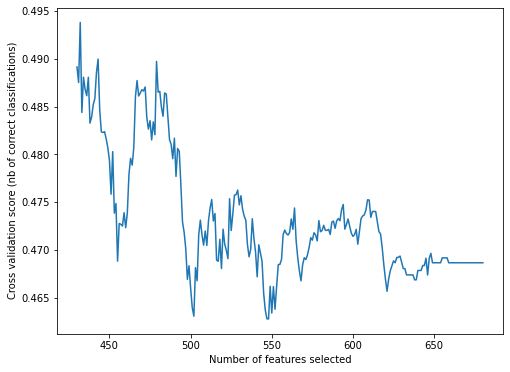

Number of features:  448
['WC_liwc', 'WPS_liwc', 'Sixltr_liwc', 'ipron_liwc', 'number_liwc', 'posemo_liwc', 'tentat_liwc', 'differ_liwc', 'percept_liwc', 'bio_liwc', 'body_liwc', 'health_liwc', 'reward_liwc', 'leisure_liwc', 'home_liwc', 'informal_liwc', 'swear_liwc', 'Period_liwc', 'Comma_liwc', 'QMark_liwc', 'PERSON_NER', 'CARDINAL_NER', 'PERCENT_NER', 'ORDINAL_NER', 'MONEY_NER', 'FAC_NER', 'abroad', 'accumul', 'achiev', 'adhd', 'administr', 'adult', 'advers', 'affirm', 'after', 'age', 'aggress', 'ahead', 'aid', 'all', 'although', 'analyz', 'antidepress', 'anyon', 'approxim', 'aren', 'autism', 'avoid', 'bacteri', 'bas', 'be', 'becaus', 'beg', 'begin', 'belief', 'berg', 'biggest', 'billion', 'bissau', 'boil', 'bore', 'both', 'bout', 'brain', 'brand', 'by', 'ca', 'california', 'caregiv', 'categori', 'causat', 'cb', 'cdc', 'center', 'charg', 'chosen', 'ci', 'circul', 'claim', 'classen', 'cognit', 'columbia', 'com', 'come', 'commiss', 'commun', 'complex', 'complic', 'comprehend', 'concer

In [218]:
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
_, _, vac_important_features = get_important_features(vaccination_X_overlap, 
                                      vaccination_Y, 
                                      num_important_features=430)

In [219]:
num_limit = 430
vac_important_features = vac_important_features[0:num_limit]

In [220]:
vac_important_features

['WC_liwc',
 'WPS_liwc',
 'Sixltr_liwc',
 'ipron_liwc',
 'number_liwc',
 'posemo_liwc',
 'tentat_liwc',
 'differ_liwc',
 'percept_liwc',
 'bio_liwc',
 'body_liwc',
 'health_liwc',
 'reward_liwc',
 'leisure_liwc',
 'home_liwc',
 'informal_liwc',
 'swear_liwc',
 'Period_liwc',
 'Comma_liwc',
 'QMark_liwc',
 'PERSON_NER',
 'CARDINAL_NER',
 'PERCENT_NER',
 'ORDINAL_NER',
 'MONEY_NER',
 'FAC_NER',
 'abroad',
 'accumul',
 'achiev',
 'adhd',
 'administr',
 'adult',
 'advers',
 'affirm',
 'after',
 'age',
 'aggress',
 'ahead',
 'aid',
 'all',
 'although',
 'analyz',
 'antidepress',
 'anyon',
 'approxim',
 'aren',
 'autism',
 'avoid',
 'bacteri',
 'bas',
 'be',
 'becaus',
 'beg',
 'begin',
 'belief',
 'berg',
 'biggest',
 'billion',
 'bissau',
 'boil',
 'bore',
 'both',
 'bout',
 'brain',
 'brand',
 'by',
 'ca',
 'california',
 'caregiv',
 'categori',
 'causat',
 'cb',
 'cdc',
 'center',
 'charg',
 'chosen',
 'ci',
 'circul',
 'claim',
 'classen',
 'cognit',
 'columbia',
 'com',
 'come',
 'comm


Generation 1 - Current best internal CV score: 0.8029880125252177

Generation 2 - Current best internal CV score: 0.8029880125252177

Generation 3 - Current best internal CV score: 0.8049376082854343

Generation 4 - Current best internal CV score: 0.8049376082854343

Generation 5 - Current best internal CV score: 0.8049376082854343

Best pipeline: MLPClassifier(MLPClassifier(input_matrix, activation=logistic, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=1000), activation=relu, hidden_layer_sizes=(30, 20), learning_rate=adaptive, max_iter=1000)


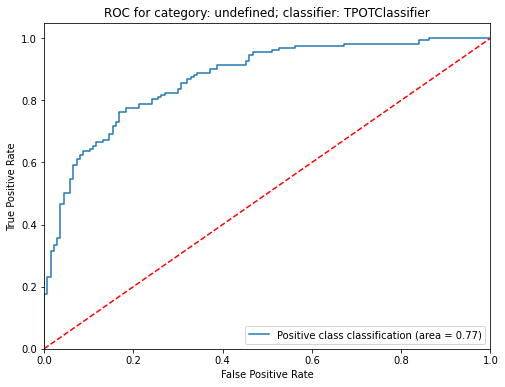

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       137
           1       0.78      0.80      0.79       152

    accuracy                           0.78       289
   macro avg       0.77      0.77      0.77       289
weighted avg       0.78      0.78      0.77       289



In [221]:
tpot_vac = teapot_optimizer(vaccination_X_overlap, 
                            vaccination_Y,
                            important_features = vac_important_features,
                            standarize=True)
vac_pipeline = tpot_vac.fitted_pipeline_.steps[-1][1]
# pickle.dump(tpot_vac.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/vac_fitted_pipeline.p','wb'))

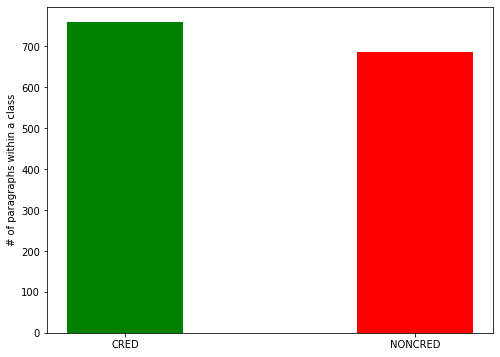

In [222]:
vac_label_counter = Counter(vaccination_Y)
plt.bar(x=['CRED', 'NONCRED'], height=vac_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()

In [223]:
mean_weighted_f1(vac_pipeline, vaccination_X_overlap[vac_important_features], vaccination_Y, 20, 0.2)

Mean weighted f1:  0.9048249420225257  STD:  0.019027428818946528
Mean micro f1:  0.9050173010380623  STD:  0.018935747072963367


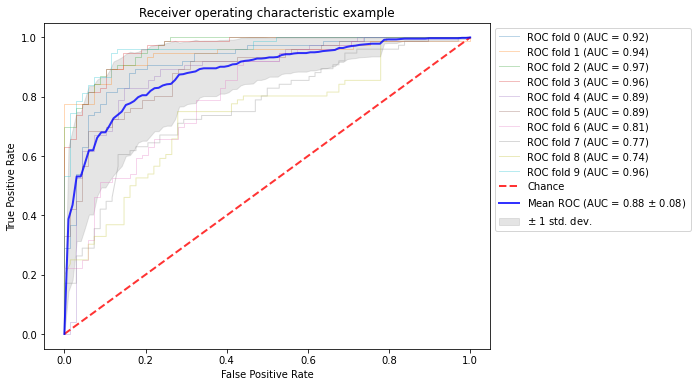

In [224]:
show_auc_for_cv(vac_pipeline, vaccination_X_overlap[vac_important_features], vaccination_Y, n_splits=10)

Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 20), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Loading LIME feature importance retrieval model...


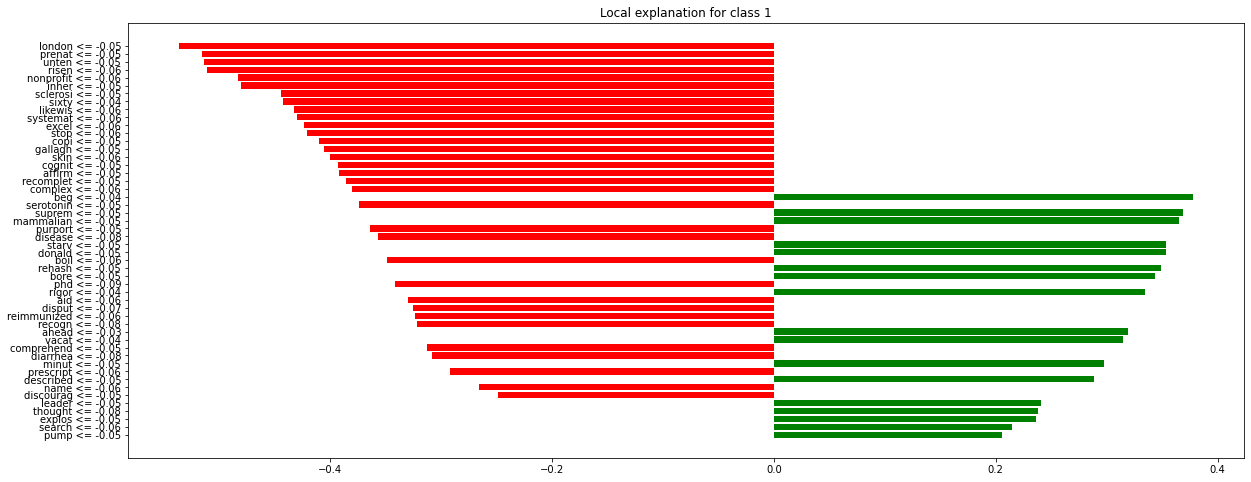

In [225]:
plt.rcParams["figure.figsize"] = (20, 8) # (w, h)
proba_1, proba_0, vaccination_clf = predict_proba_hist(vac_pipeline, 
                                      vaccination_X_overlap, 
                                      vaccination_Y, 
                                      vac_important_features)

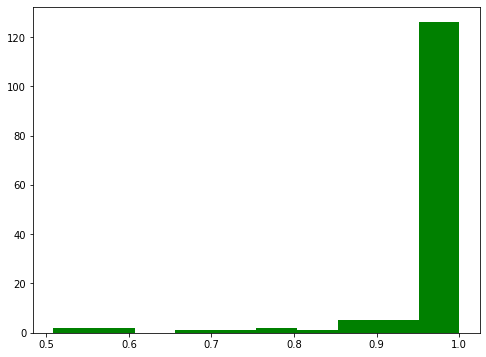

In [226]:
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

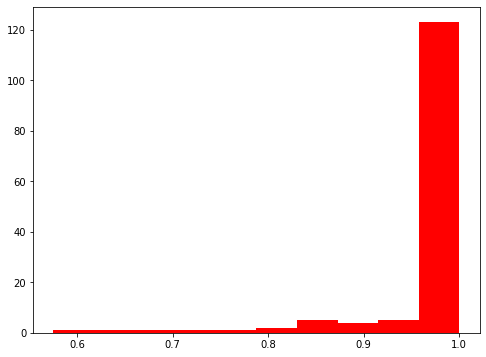

In [227]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

### Non-overlapping paragraphs

In [234]:
print(np.shape(vaccination_X))
print(np.shape(vaccination_Y))

(482, 2854)
(482,)


Running RFE to find the most supportive features
Optimal number of features : 1434


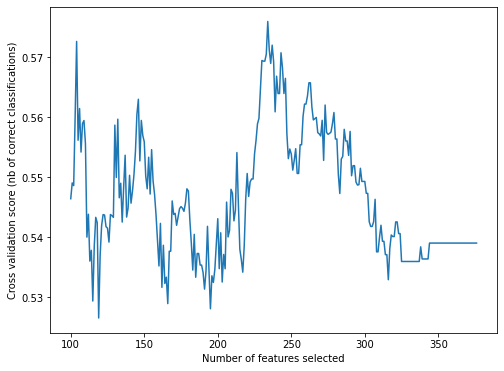

Number of features:  1434
['WC_liwc', 'WPS_liwc', 'Sixltr_liwc', 'Dic_liwc', 'pronoun_liwc', 'we_liwc', 'you_liwc', 'they_liwc', 'ipron_liwc', 'auxverb_liwc', 'adverb_liwc', 'conj_liwc', 'verb_liwc', 'compare_liwc', 'interrog_liwc', 'anx_liwc', 'social_liwc', 'insight_liwc', 'cause_liwc', 'tentat_liwc', 'differ_liwc', 'body_liwc', 'health_liwc', 'drives_liwc', 'reward_liwc', 'risk_liwc', 'motion_liwc', 'leisure_liwc', 'money_liwc', 'relig_liwc', 'death_liwc', 'informal_liwc', 'swear_liwc', 'nonflu_liwc', 'AllPunc_liwc', 'Period_liwc', 'Comma_liwc', 'Dash_liwc', 'Parenth_liwc', 'DATE_NER', 'ORG_NER', 'GPE_NER', 'CARDINAL_NER', 'ORDINAL_NER', 'NORP_NER', 'MONEY_NER', 'TIME_NER', 'aaa', 'aabi', 'abnorm', 'abort', 'about', 'abroad', 'abstract', 'academi', 'acceler', 'accept', 'accord', 'accordingli', 'account', 'achiev', 'act', 'action', 'activ', 'add', 'addit', 'adhd', 'adjust', 'administr', 'adult', 'advis', 'advocaci', 'affirm', 'afghanistan', 'after', 'ag', 'against', 'age', 'ago', 'ag

In [236]:
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
_, _, vac_important_features = get_important_features(vaccination_X, 
                                      vaccination_Y, 
                                      num_important_features=100)

In [237]:
num_limit = 140
vac_important_features = vac_important_features[0:num_limit]


Generation 1 - Current best internal CV score: 0.6887085137085137

Generation 2 - Current best internal CV score: 0.6887085137085137

Generation 3 - Current best internal CV score: 0.6936868686868688

Generation 4 - Current best internal CV score: 0.6993434343434343

Generation 5 - Current best internal CV score: 0.6993434343434343

Best pipeline: LogisticRegression(MLPClassifier(input_matrix, activation=relu, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=1000), class_weight=balanced, max_iter=10000)


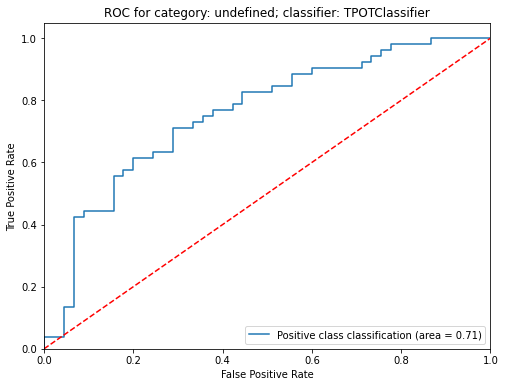

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        45
           1       0.74      0.71      0.73        52

    accuracy                           0.71        97
   macro avg       0.71      0.71      0.71        97
weighted avg       0.71      0.71      0.71        97



In [238]:
tpot_vac = teapot_optimizer(vaccination_X, 
                            vaccination_Y,
                            important_features = vac_important_features,
                            standarize=True)
vac_pipeline = tpot_vac.fitted_pipeline_.steps[-1][1]

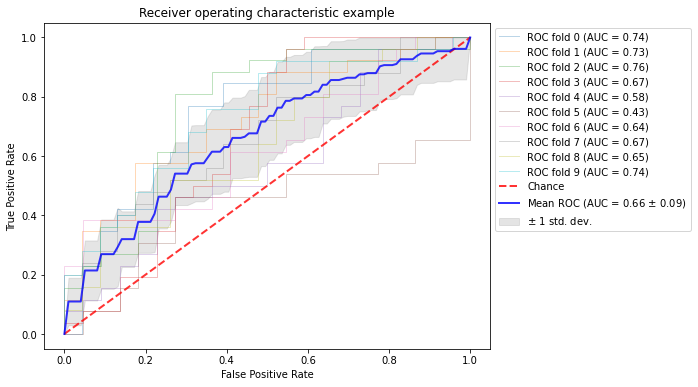

In [239]:
show_auc_for_cv(vac_pipeline, vaccination_X[vac_important_features], vaccination_Y, n_splits=10)

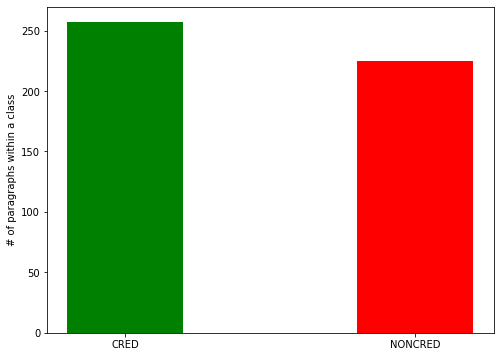

In [240]:
vac_label_counter = Counter(vaccination_Y)
plt.bar(x=['CRED', 'NONCRED'], height=vac_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()

Model: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


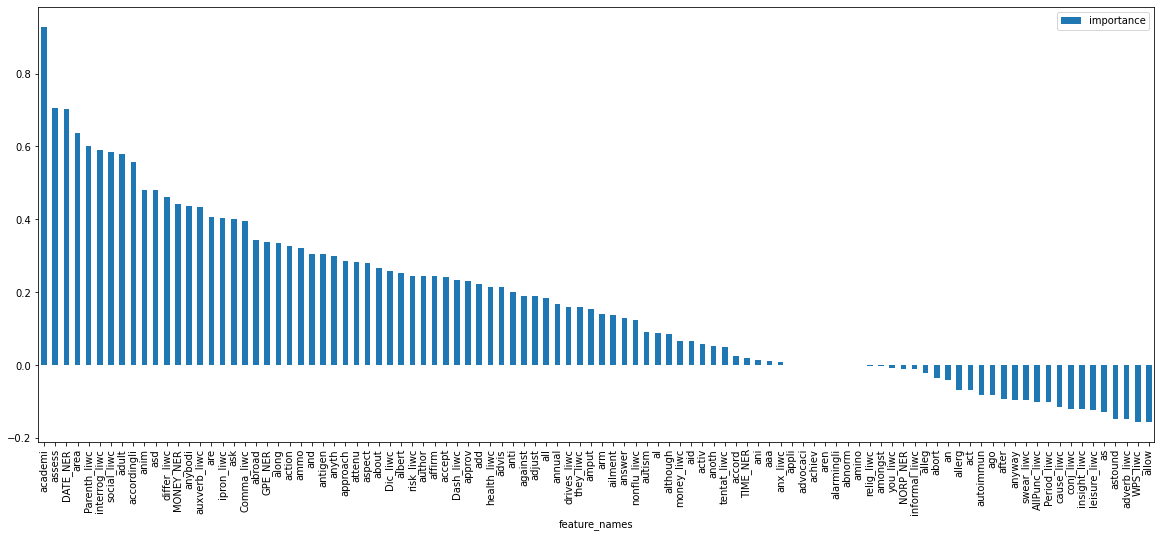

In [243]:
plt.rcParams["figure.figsize"] = (20, 8) # (w, h)
proba_1, proba_0, vaccination_clf = predict_proba_hist(vac_pipeline, 
                                      vaccination_X, 
                                      vaccination_Y, 
                                      vac_important_features)

## statins

### Overlapping paragraphs

In [ ]:
print(np.shape(statins_X_overlap))
print(np.shape(statins_Y))

In [ ]:
1917*0.3

In [ ]:
statins_X_overlap.head()

In [ ]:
_, _, statins_important_features = get_important_features(statins_X_overlap, 
                                      statins_Y, 
                                      num_important_features=575)

Number of important festure for the current visualization is: 1140


Generation 1 - Current best internal CV score: 0.7724213542117969

Generation 2 - Current best internal CV score: 0.7789461592794272

Generation 3 - Current best internal CV score: 0.7789461592794272

Generation 4 - Current best internal CV score: 0.7789461592794272

Generation 5 - Current best internal CV score: 0.7820022546342561

Best pipeline: MLPClassifier(GradientBoostingClassifier(input_matrix), activation=logistic, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=1000)


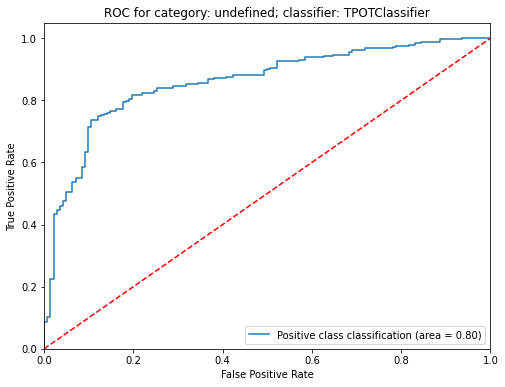

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       142
           1       0.89      0.77      0.83       242

    accuracy                           0.79       384
   macro avg       0.78      0.80      0.79       384
weighted avg       0.81      0.79      0.80       384



In [206]:
tpot_statins = teapot_optimizer(statins_X_overlap, 
                             statins_Y,
                             important_features = statins_important_features)
# pickle.dump(tpot_stat.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/stat_fitted_pipeline.p','wb'))

In [207]:
statins_fitted_pipeline = tpot_statins.fitted_pipeline_.steps[-1][1]

In [ ]:
stat_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/stat_fitted_pipeline.p','rb'))

In [ ]:
stat_important_features = ['Dic', 'function', 'pronoun', 'shehe', 'ipron', 'adverb', 'negate', 'interrog', 'friend', 'cogproc', 'cause', 'focusfuture', 'money', 'Period', 'QMark', 'Dash', 'GPE', 'TIME', 'WORK_OF_ART', 'abil', 'academ', 'accept', 'accus', 'ach', 'acid', 'across', 'al', 'alon', 'alreadi', 'also', 'among', 'analys', 'angri', 'apoprotein', 'appar', 'arora', 'assess', 'assum', 'asterisk', 'at', 'attent', 'bake', 'becom', 'behind', 'below', 'better', 'bile', 'blame', 'blind', 'blog', 'blood', 'boast', 'bottl', 'bottom', 'bowden', 'bp', 'burden', 'businessweek', 'cancer', 'case', 'cataract', 'cdc', 'centr', 'centuri', 'certain', 'chanc', 'chose', 'cite', 'close', 'clot', 'column', 'common', 'compar', 'complic', 'conclud', 'conclus', 'consider', 'constrict', 'consum', 'consumption', 'contain', 'contradict', 'contrast', 'convent', 'convinc', 'coq', 'cortison', 'cours', 'creatin', 'crucial', 'ctt', 'current', 'declar', 'defin', 'deliber', 'demand', 'dementia', 'deposit', 'depress', 'deriv', 'design', 'destabil', 'destroy', 'diabet', 'diagnos', 'diagnosi', 'didn', 'diet', 'differ', 'difficult', 'digest', 'director', 'disease', 'dispos', 'do', 'doctor', 'domin', 'dos', 'dosag', 'doses', 'doubl', 'dramat', 'drastic', 'drew', 'drink', 'each', 'easi', 'eat', 'editor', 'effici', 'encourag', 'enig', 'entir', 'epidem', 'equival', 'eschew', 'everybodi', 'evidence', 'exact', 'exagger', 'excess', 'explor', 'express', 'fact', 'factor', 'fairli', 'fallon', 'fals', 'fatigu', 'fewer', 'fibr', 'flour', 'fluffi', 'food', 'for', 'forc', 'fortun', 'frame', 'from', 'fructos', 'fulli', 'gain', 'give', 'glanc', 'glia', 'gone', 'gp', 'grain', 'grass', 'green', 'grill', 'gun', 'hand', 'health', 'herein', 'hi', 'ideal', 'identif', 'ignor', 'ill', 'inabl', 'indiffer', 'inflamm', 'influenti', 'inform', 'inhibitor', 'insuffici', 'insur', 'intens', 'interest', 'intermedi', 'intestin', 'invest', 'involv', 'jama', 'job', 'journal', 'just', 'kept', 'kinas', 'landmark', 'last', 'late', 'legaci', 'lenfant', 'liabl', 'lie', 'life', 'lifestyl', 'lifetim', 'lipitor', 'list', 'liter', 'liver', 'long', 'look', 'lou', 'lower', 'lowest', 'man', 'mann', 'marilyn', 'marker', 'market', 'may', 'measur', 'mediat', 'medic', 'medicin', 'meet', 'metabol', 'metal', 'microwav', 'mid', 'middl', 'might', 'mind', 'money', 'monitor', 'multipl', 'munich', 'muscl', 'myalgia', 'myth', 'narrow', 'nasti', 'never', 'nhlbi', 'nih', 'nine', 'normal', 'not', 'notic', 'notifi', 'notion', 'now', 'numer', 'obese', 'obtain', 'often', 'oil', 'old', 'oliv', 'omega', 'or', 'out', 'outlin', 'over', 'overestim', 'pan', 'particip', 'particl', 'particularli', 'patient', 'pattern', 'percent', 'percentag', 'perform', 'pharmaceut', 'pharmaci', 'phenomenon', 'plaqu', 'plu', 'polyunsatur', 'pool', 'possibl', 'potenti', 'predispos', 'prefer', 'presenc', 'price', 'prize', 'probabl', 'proper', 'pure', 'qual', 'quarter', 'radic', 'rate', 'ratio', 'raw', 'realis', 'recent', 'recommend', 'record', 'reduc', 'refut', 'regularly', 'repeatedli', 'report', 'repres', 'resist', 'respect', 'restor', 'return', 'rice', 'sachdev', 'sale', 'same', 'sav', 'scientist', 'score', 'seafood', 'seem', 'seen', 'seriou', 'serv', 'set', 'shellfish', 'shop', 'should', 'shuttl', 'silenc', 'sir', 'slight', 'sober', 'sold', 'sole', 'solut', 'spike', 'standard', 'statement', 'statin', 'statist', 'steam', 'store', 'studi', 'submit', 'substanti', 'such', 'supplement', 'surrog', 'synergis', 'synthesi', 'take', 'talk', 'task', 'team', 'telegraph', 'tell', 'term', 'themselv', 'these', 'thicken', 'thing', 'third', 'threaten', 'three', 'too', 'topol', 'total', 'tran', 'tri', 'trigylcerid', 'trump', 'turn', 'twelv', 'two', 'unhealthi', 'unusu', 'upon', 'valid', 'vari', 'varieti', 've', 'we', 'webmd', 'weight', 'what', 'when', 'whi', 'who', 'wildli', 'word', 'worri', 'wors', 'worthwhil', 'written', 'zero', 'polarity']

In [208]:
mean_weighted_f1(statins_fitted_pipeline, statins_X_overlap[statins_important_features], statins_Y, 20, 0.2)

Mean weighted f1:  0.888395008221023  STD:  0.019302490254897647
Mean micro f1:  0.8893229166666666  STD:  0.018624799006186167


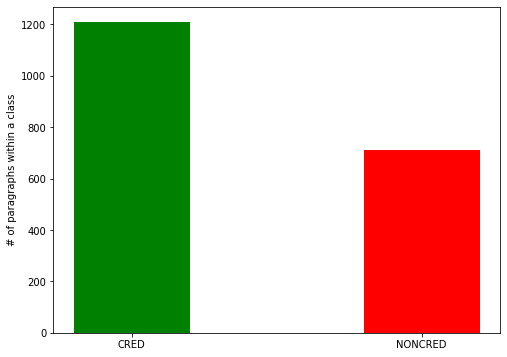

In [209]:
stat_label_counter = Counter(statins_Y)
plt.bar(x=['CRED', 'NONCRED'], height=stat_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()

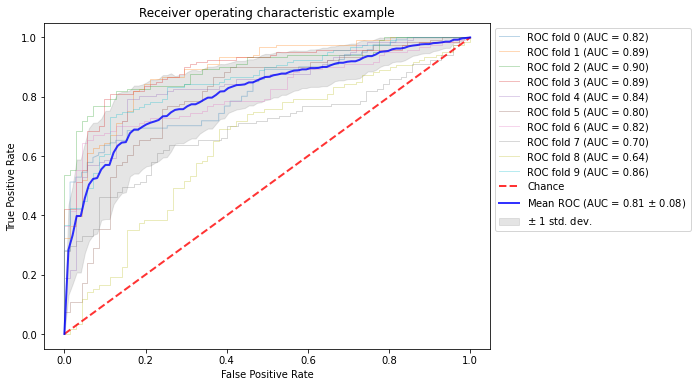

In [210]:
show_auc_for_cv(statins_fitted_pipeline, statins_X_overlap[statins_important_features], statins_Y, n_splits=10)

Model: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 20), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Loading LIME feature importance retrieval model...


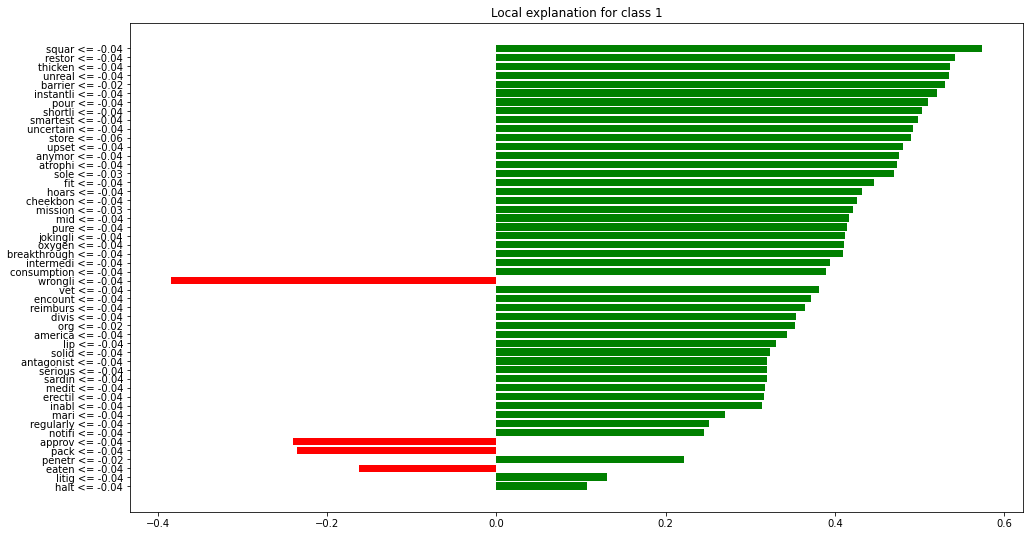

In [212]:
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)
proba_1, proba_0, statins_clf = predict_proba_hist(statins_fitted_pipeline, 
                                      statins_X_overlap , 
                                      statins_Y, 
                                      statins_important_features)

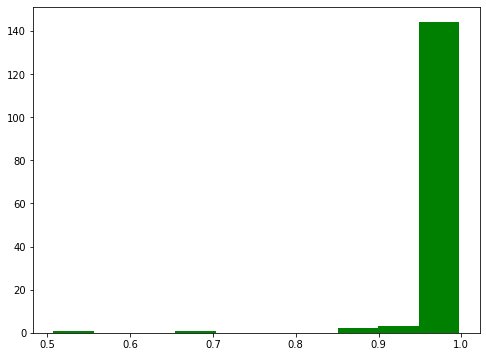

In [213]:
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

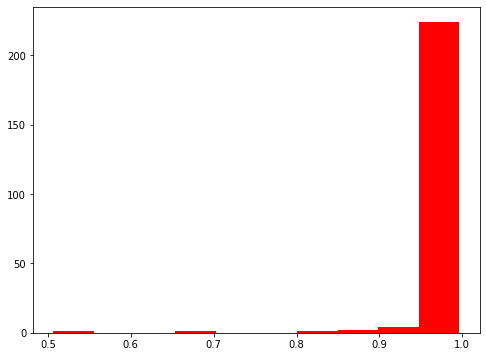

In [214]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

### Non-overlapping paragraphs

In [244]:
print(np.shape(statins_X))
print(np.shape(statins_Y))

(639, 3464)
(639,)


Running RFE to find the most supportive features
Optimal number of features : 774


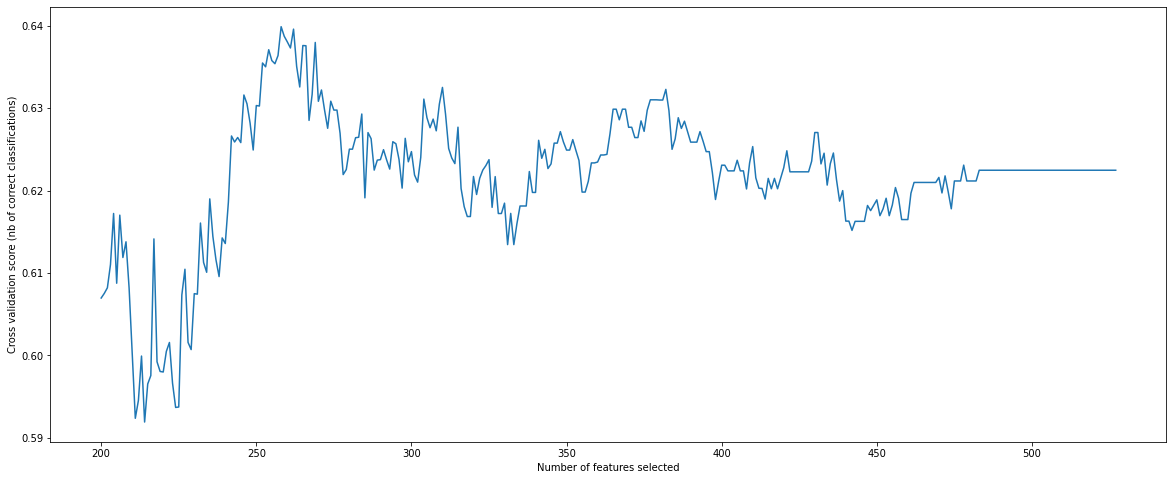

Number of features:  774
['Analytic_liwc', 'Authentic_liwc', 'Dic_liwc', 'function_liwc', 'pronoun_liwc', 'ppron_liwc', 'shehe_liwc', 'ipron_liwc', 'adverb_liwc', 'negate_liwc', 'interrog_liwc', 'number_liwc', 'friend_liwc', 'cogproc_liwc', 'cause_liwc', 'bio_liwc', 'health_liwc', 'ingest_liwc', 'focuspast_liwc', 'focuspresent_liwc', 'focusfuture_liwc', 'space_liwc', 'money_liwc', 'assent_liwc', 'Period_liwc', 'Comma_liwc', 'QMark_liwc', 'Dash_liwc', 'Apostro_liwc', 'GPE_NER', 'DATE_NER', 'LOC_NER', 'TIME_NER', 'abil', 'abl', 'absolut', 'abstract', 'academi', 'accept', 'access', 'accur', 'accus', 'ach', 'acid', 'acids', 'across', 'activ', 'actual', 'address', 'adequ', 'advanc', 'advis', 'agre', 'al', 'albacor', 'alcohol', 'almond', 'alon', 'along', 'alreadi', 'also', 'among', 'amount', 'an', 'analys', 'angiogram', 'angri', 'antibiot', 'antioxid', 'apoprotein', 'appar', 'area', 'argu', 'argument', 'arora', 'artery', 'arthriti', 'assess', 'asterisk', 'at', 'ate', 'atherosclerosi', 'atorv

In [245]:
_, _, statins_important_features = get_important_features(statins_X, 
                                      statins_Y, 
                                      num_important_features=200)

In [247]:
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)
num_limit = 190
statins_important_features = statins_important_features[0:num_limit]


Generation 1 - Current best internal CV score: 0.7222894882894882

Generation 2 - Current best internal CV score: 0.7222894882894882

Generation 3 - Current best internal CV score: 0.7222894882894882

Generation 4 - Current best internal CV score: 0.7354711954711954

Generation 5 - Current best internal CV score: 0.7354711954711954

Best pipeline: MLPClassifier(CombineDFs(input_matrix, input_matrix), activation=relu, hidden_layer_sizes=(50, 20), learning_rate=adaptive, max_iter=1000)


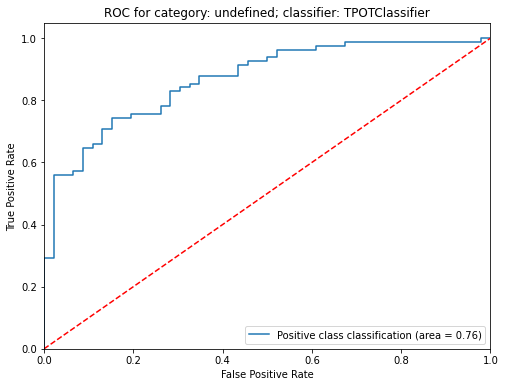

              precision    recall  f1-score   support

           0       0.66      0.72      0.69        46
           1       0.83      0.79      0.81        82

    accuracy                           0.77       128
   macro avg       0.75      0.76      0.75       128
weighted avg       0.77      0.77      0.77       128



In [248]:
tpot_statins = teapot_optimizer(statins_X, 
                             statins_Y,
                             important_features = statins_important_features)
# pickle.dump(tpot_stat.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/stat_fitted_pipeline.p','wb'))

In [249]:
statins_fitted_pipeline = tpot_statins.fitted_pipeline_.steps[-1][1]

In [251]:
mean_weighted_f1(statins_fitted_pipeline, statins_X[statins_important_features], statins_Y, 20, 0.2)

Mean weighted f1:  0.6643338024047044  STD:  0.043982760811846267
Mean micro f1:  0.667578125  STD:  0.042895889931867305


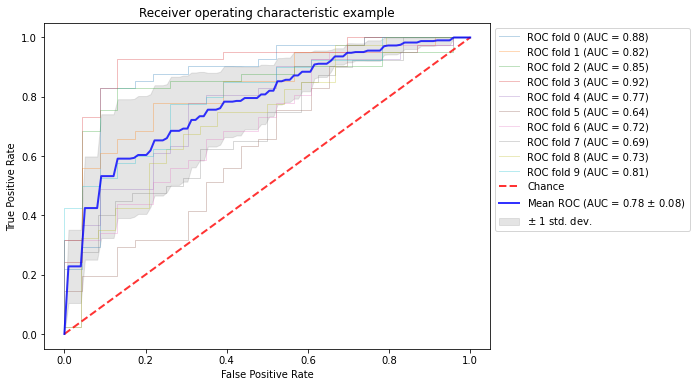

In [252]:
show_auc_for_cv(statins_fitted_pipeline, statins_X[statins_important_features], statins_Y, n_splits=10)

Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 20), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Loading LIME feature importance retrieval model...


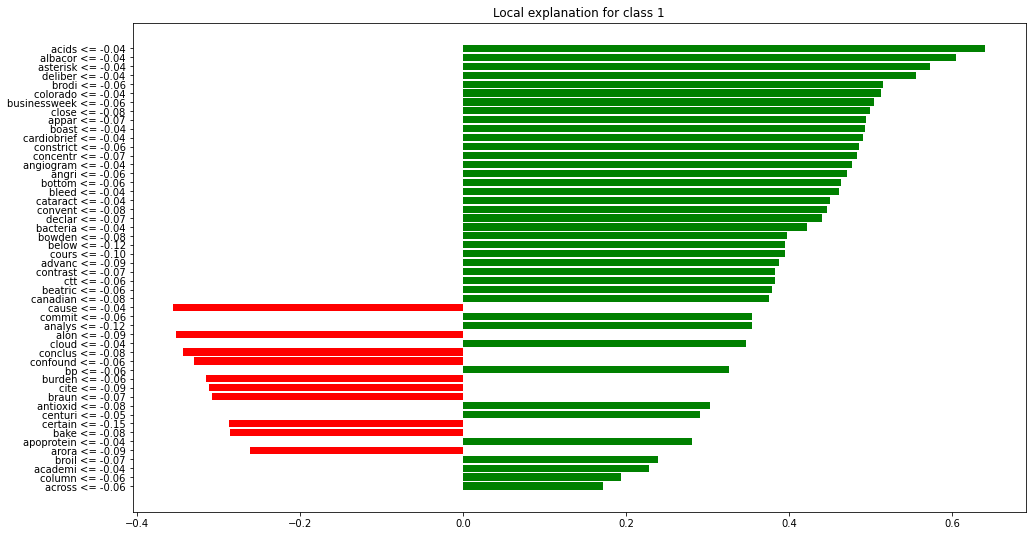

In [253]:
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)
proba_1, proba_0, statins_clf = predict_proba_hist(statins_fitted_pipeline, 
                                      statins_X, 
                                      statins_Y, 
                                      statins_important_features)

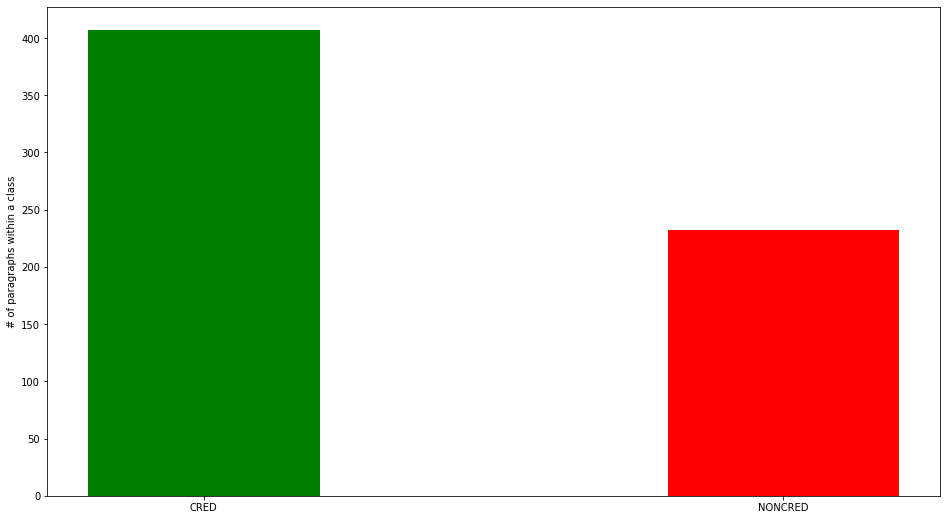

In [254]:
stat_label_counter = Counter(statins_Y)
plt.bar(x=['CRED', 'NONCRED'], height=stat_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()

## ssri_during_pregnancy

In [ ]:
_, _, ssri_during_pregnancy_important_features = get_important_features(ssri_during_pregnancy_X, 
                                      ssri_during_pregnancy_Y, 
                                      num_important_features=100, 
                                      num_limit=50)

In [ ]:
tpot_ssri_during_pregnancy = teapot_optimizer(ssri_during_pregnancy_X, 
                             ssri_during_pregnancy_Y,
                             important_features = ssri_during_pregnancy_important_features,
                             VALIDATION_SPLIT=0.3,
                             scoring='f1_weighted',
                             cv=5)
ssri_during_pregnancy_fitted_pipeline = tpot_ssri_during_pregnancy.fitted_pipeline_.steps[-1][1]
# pickle.dump(tpot_ssri.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/ssri_fitted_pipeline.p','wb'))

In [ ]:
ssri_important_features = ['Analytic', 'Clout', 'Authentic', 'Tone', 'Dic', 'function', 'pronoun', 'ppron', 'you', 'they', 'article', 'adverb', 'conj', 'verb', 'adj', 'compare', 'interrog', 'number', 'anx', 'social', 'family', 'friend', 'male', 'insight', 'cause', 'see', 'hear', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'achieve', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'time', 'work', 'leisure', 'home', 'money', 'death', 'informal', 'netspeak', 'AllPunc', 'Period', 'Comma', 'SemiC', 'Dash', 'Quote', 'Parenth', 'OtherP', 'PERSON', 'PERCENT', 'LOC', 'aa', 'abil', 'access', 'accompani', 'accord', 'accordingli', 'account', 'acid', 'across', 'act', 'ad', 'address', 'admiss', 'adult', 'advers', 'ae', 'affect', 'against', 'age', 'aj', 'al', 'all', 'also', 'am', 'amarillo', 'american', 'among', 'amount', 'amygdala', 'analysi', 'and', 'ani', 'anick', 'anim', 'anti', 'antidepress', 'appear', 'area', 'assess', 'at', 'author', 'autism', 'balanc', 'base', 'been', 'berard', 'besid', 'better', 'between', 'beyond', 'bifida', 'bipolar', 'birth', 'blood', 'bloodstream', 'bmj', 'board', 'brain', 'bt', 'but', 'cal', 'call', 'can', 'canada', 'candela', 'cardiac', 'care', 'carri', 'ce', 'cent', 'certifi', 'chang', 'chemic', 'child', 'childhood', 'children', 'choic', 'cipralex', 'circuitri', 'citalopram', 'citi', 'claudia', 'clear', 'clinic', 'close', 'clue', 'coauthor', 'cognit', 'colleagu', 'columbia', 'common', 'compar', 'concentr', 'conclud', 'confus', 'consid', 'consult', 'continu', 'contrast', 'contribut', 'correl', 'cortex', 'critic', 'current', 'days', 'dec', 'defect', 'definit', 'delay', 'deliveri', 'depression', 'depressive', 'develop', 'diaz', 'differ', 'difficulti', 'directli', 'discontinu', 'disord', 'disrupt', 'distress', 'do', 'doe', 'doesn', 'durat', 'dure', 'earli', 'educ', 'effici', 'either', 'element', 'email', 'emeritu', 'emot', 'england', 'epidemiolog', 'especi', 'et', 'even', 'everyth', 'exactli', 'examin', 'expect', 'explor', 'exposur', 'factor', 'feb', 'fellow', 'few', 'financi', 'find', 'first', 'fitzgerald', 'five', 'focu', 'follow', 'form', 'forms', 'four', 'from', 'function', 'further', 'gener', 'get', 'given', 'grey', 'grow', 'had', 'hard', 'hartz', 'health', 'hendrick', 'hernandez', 'hi', 'highest', 'highli', 'histori', 'howev', 'hub', 'human', 'hypertens', 'identifi', 'ill', 'immedi', 'impair', 'implic', 'incomplet', 'individu', 'inf', 'influenc', 'inhibitor', 'insuffici', 'insular', 'integr', 'intens', 'into', 'investig', 'involv', 'iq', 'irv', 'isn', 'jiook', 'journal', 'joy', 'juli', 'jun', 'keep', 'key', 'knowledg', 'known', 'kostara', 'late', 'lech', 'left', 'less', 'level', 'levi', 'lik', 'lin', 'linger', 'link', 'longer', 'louik', 'low', 'lower', 'lugo', 'made', 'major', 'mani', 'matter', 'mean', 'meanwhil', 'medic', 'mental', 'meta', 'might', 'mild', 'miscarriag', 'misri', 'mitchel', 'mm', 'monitor', 'month', 'montreal', 'motiv', 'motor', 'must', 'need', 'neonat', 'nerv', 'neural', 'neurolog', 'never', 'new', 'newborn', 'nicu', 'no', 'non', 'normal', 'nortriptylin', 'note', 'nov', 'nurs', 'oberland', 'occur', 'of', 'older', 'on', 'one', 'onli', 'order', 'osborn', 'other', 'our', 'outcom', 'over', 'oxygen', 'pair', 'paroxetin', 'pass', 'patient', 'pediatr', 'percent', 'persist', 'pharmacolog', 'phenomena', 'pictur', 'placenta', 'plasma', 'pool', 'poor', 'pose', 'post', 'postdoctor', 'postnat', 'postpartum', 'pregnanc', 'problem', 'proce', 'produc', 'professor', 'proport', 'provid', 'prozac', 'psychiatri', 'psychologist', 'psychotherapi', 'psychotrop', 'publish', 'pulmonari', 'rais', 'randomli', 'rapidli', 'rare', 'ratio', 'reaction', 'realist', 'realli', 'reassur', 'receiv', 'recent', 'record', 'refer', 'regard', 'region', 'regul', 'rel', 'remedi', 'reproduct', 'research', 'reserv', 'respond', 'reuptak', 'reuter', 'rigg', 'right', 'risk', 'robust', 'rule', 'rurak', 'safe', 'safer', 'satur', 'say', 'scan', 'school', 'second', 'seizur', 'select', 'self', 'sens', 'sensit', 'serotonin', 'seroxat', 'seventi', 'shorter', 'side', 'similar', 'singl', 'size', 'skill', 'sleep', 'smoke', 'smultan', 'so', 'socioeconom', 'some', 'spina', 'spinal', 'ssri', 'stabl', 'state', 'still', 'stop', 'strongest', 'struggl', 'studi', 'studying', 'subject', 'subsequ', 'substanti', 'suggest', 'suicid', 'supervis', 'surpris', 'symptom', 'syndrom', 'tackett', 'tech', 'tell', 'term', 'texa', 'tf', 'that', 'their', 'them', 'there', 'therefor', 'those', 'thought', 'three', 'through', 'transfer', 'transient', 'treat', 'trimest', 'tube', 'unansw', 'unclear', 'underweight', 'uneasi', 'unit', 'univers', 'unless', 'use', 'valproic', 'valu', 'via', 'volum', 'wasn', 'watch', 'way', 'weak', 'weight', 'weissman', 'weren', 'werler', 'which', 'while', 'white', 'whitelaw', 'who', 'will', 'wind', 'withdraw', 'within', 'without', 'woman', 'womb', 'women', 'work', 'worth', 'year', 'york', 'your', 'zero', 'polarity', 'subjectivity']
ssri_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/ssri_fitted_pipeline.p','rb'))
mean_weighted_f1(ssri_pipeline, ssri_during_pregnancy_X[ssri_important_features], ssri_during_pregnancy_Y, 10, 0.3)

In [ ]:
mean_weighted_f1(ssri_during_pregnancy_fitted_pipeline, 
                 ssri_during_pregnancy_X[ssri_during_pregnancy_important_features], 
                 ssri_during_pregnancy_Y, 
                 5, 
                 0.3)

In [ ]:
show_auc_for_cv(ssri_during_pregnancy_fitted_pipeline, 
                ssri_during_pregnancy_X[ssri_during_pregnancy_important_features], 
                ssri_during_pregnancy_Y, 
                n_splits=5)

In [ ]:
proba_1, proba_0, ssri_clf = predict_proba_hist(ssri_during_pregnancy_fitted_pipeline, 
                                                ssri_during_pregnancy_X, 
                                                ssri_during_pregnancy_Y, 
                                                ssri_during_pregnancy_important_features)

In [ ]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

In [ ]:
plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

## antioxidants

In [ ]:
np.shape(antioxidants_X)

In [ ]:
plt.rcParams["figure.figsize"] = (8, 9) # (w, h)
_, _, antioxidants_important_features = get_important_features(antioxidants_X, 
                                      antioxidants_Y, 
                                      num_important_features=100, 
                                      num_limit=60)

In [ ]:
tpot_antiox = teapot_optimizer(antioxidants_X, 
                               antioxidants_Y, 
                               important_features = antioxidants_important_features,
                               VALIDATION_SPLIT=0.3)


In [ ]:
antioxidants_fitted_pipeline = antitpot_antiox.fitted_pipeline_.steps[-1][1]

In [ ]:
pickle.dump(tpot_antiox.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/antiox_fitted_pipeline.p','wb'))

In [ ]:
antioxidants_important_features = ['Tone', 'pronoun', 'they', 'ipron', 'conj', 'adj', 'posemo', 'negemo', 'anx', 'friend', 'cogproc', 'cause', 'certain', 'bio', 'health', 'ingest', 'Colon', 'Apostro', 'abil', 'abnorm', 'about', 'accord', 'acn', 'acorn', 'acétat', 'ad', 'aim', 'all', 'allevi', 'alon', 'alway', 'amino', 'and', 'anoth', 'anti', 'antioxid', 'appetit', 'ask', 'assum', 'attribut', 'be', 'becaus', 'benefit', 'bioavail', 'blind', 'bon', 'bring', 'but', 'can', 'caus', 'certain', 'chain', 'cite', 'cold', 'color', 'complex', 'consult', 'consum', 'contributor', 'copper', 'correct', 'creat', 'criteria', 'critic', 'crucial', 'curcumin', 'damage', 'death', 'deduc', 'defenc', 'defici', 'definit', 'delici', 'deriv', 'destroy', 'destruct', 'develop', 'doctor', 'doe', 'doesn', 'done', 'dose', 'double', 'down', 'easili', 'eat', 'either', 'element', 'especi', 'eventu', 'evid', 'excel', 'exercis', 'explain', 'extent', 'extract', 'fact', 'fan', 'first', 'focu', 'fruit', 'glutathion', 'go', 'grape', 'groceri', 'hand', 'harm', 'have', 'haven', 'heart', 'here', 'ill', 'immun', 'incorpor', 'individu', 'ingest', 'intens', 'interest', 'interestingli', 'into', 'investig', 'involv', 'iu', 'kale', 'kill', 'legum', 'lipid', 'live', 'loss', 'lung', 'manufactur', 'mean', 'measur', 'mediat', 'mice', 'miner', 'mitochondria', 'most', 'must', 'nano', 'necessari', 'neuropathi', 'no', 'offici', 'oil', 'older', 'oliv', 'one', 'opposit', 'optim', 'outnumb', 'peopl', 'person', 'pharmacist', 'phosphat', 'placebo', 'portion', 'powder', 'powerhous', 'pregnant', 'process', 'promis', 'protect', 'prove', 'radiat', 'rank', 'reaction', 'read', 'realli', 'regardless', 'regimen', 'relat', 'reliev', 'revers', 'scientist', 'significantli', 'singl', 'smaller', 'smoke', 'so', 'sometim', 'spirulina', 'squash', 'stabil', 'statist', 'stimul', 'stop', 'strawberri', 'such', 'suggest', 'sunburn', 'suppress', 'sure', 'system', 'systol', 'talk', 'tea', 'thank', 'them', 'thi', 'thing', 'think', 'three', 'through', 'tissu', 'to', 'tocophérol', 'toxin', 'transport', 'trend', 'triglycerid', 'two', 'ultim', 'unclear', 'usag', 'variou', 'veget', 'virus', 'wake', 'wall', 'way', 'west', 'what', 'which', 'who', 'will', 'with', 'world', 'worst', 'worth', 'you', 'zimax']
_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/antiox_fitted_pipeline.p','rb'))
clf = LogisticRegression(class_weight='balanced', max_iter=10000)

In [ ]:
mean_weighted_f1(antioxidants_pipeline, antioxidants_X[antioxidants_important_features], antioxidants_Y, 10, 0.3)

In [ ]:
antioxidants_label_counter = Counter(antioxidants_Y)
plt.bar(x=['NONCRED', 'CRED'], height=antioxidants_label_counter.values(), width=0.4, color=['r', 'g'])
plt.ylabel('# of paragraphs within a class')
plt.show()
antioxidants_label_counter

In [ ]:
show_auc_for_cv(antioxidants_pipeline, antioxidants_X[antioxidants_important_features], antioxidants_Y, n_splits=10)

In [ ]:
proba_1, proba_0, antioxidants_clf = predict_proba_hist(antioxidants_fitted_pipeline, 
                                      antioxidants_X, 
                                      antioxidants_Y, 
                                      antioxidants_important_features)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

## psychiatry

In [ ]:
np.shape(psychiatry_X)

In [ ]:
psychiatry_important_features, tpot_psych = teapot_optimizer(psychiatry_X, 
                               psychiatry_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.2)
pickle.dump(tpot_psych.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/psych_fitted_pipeline.p','wb'))

In [ ]:
psychiatry_important_features = ['Sixltr', 'Dic', 'friend', 'certain', 'percept', 'see', 'bio', 'health', 'focuspresent', 'Parenth', 'PERCENT', 'TIME', 'accomplish', 'achiev', 'address', 'administr', 'advanc', 'advis', 'agent', 'agre', 'al', 'allevi', 'am', 'anim', 'anxieti', 'anxiou', 'appear', 'appreci', 'appropri', 'approv', 'aren', 'ask', 'assist', 'assum', 'attempt', 'averag', 'babi', 'balanc', 'barbar', 'barber', 'began', 'behav', 'big', 'blurri', 'bodi', 'both', 'breakup', 'breath', 'brochur', 'bullshit', 'canadian', 'cancer', 'center', 'certain', 'character', 'clear', 'clearli', 'commiss', 'commonli', 'compassion', 'compli', 'composit', 'compuls', 'confer', 'conflict', 'continu', 'convinc', 'cora', 'correct', 'cyr', 'damag', 'damage', 'date', 'dealt', 'debat', 'decent', 'deeper', 'delay', 'deliber', 'depart', 'descript', 'desper', 'diagnosi', 'did', 'didn', 'differ', 'difficulti', 'disappear', 'discontinu', 'disorders', 'dispel', 'dizzi', 'doctor', 'document', 'dog', 'dollar', 'doubl', 'drapetomania', 'drug', 'durat', 'dyskinesia', 'edema', 'els', 'embarrass', 'encount', 'encourag', 'enrich', 'entir', 'enzym', 'epilepsi', 'equal', 'erectil', 'eventu', 'excit', 'execut', 'explain', 'extens', 'extent', 'extrem', 'failur', 'felt', 'find', 'forget', 'free', 'freelanc', 'friend', 'fundament', 'gari', 'gemma', 'give', 'gold', 'gotten', 'gp', 'grate', 'grow', 'guy', 'gynecologist', 'happen', 'harrow', 'heal', 'health', 'heartbeat', 'higher', 'histor', 'hiv', 'hope', 'hypertens', 'idea', 'identifi', 'impair', 'impuls', 'incid', 'includ', 'inde', 'indic', 'individu', 'influenti', 'inhibit', 'instead', 'institut', 'intens', 'interact', 'introduc', 'it', 'joke', 'joul', 'judi', 'just', 'kesey', 'kess', 'ketamin', 'kramer', 'largest', 'later', 'learn', 'lectur', 'led', 'let', 'life', 'likelihood', 'link', 'list', 'liver', 'loss', 'lucki', 'mainstream', 'manner', 'maoi', 'map', 'matter', 'mayb', 'mechan', 'med', 'media', 'memori', 'merit', 'mess', 'mind', 'mistak', 'moment', 'monthli', 'mood', 'motiv', 'movement', 'movi', 'must', 'myth', 'nardil', 'nazi', 'neurotransmiss', 'news', 'nicotin', 'nobodi', 'non', 'noradrenalin', 'nordic', 'normal', 'notabl', 'numer', 'object', 'obviou', 'occupi', 'odd', 'offic', 'oh', 'organis', 'outweigh', 'pad', 'parti', 'partnership', 'pay', 'per', 'perhap', 'pharma', 'pharmaci', 'philosophi', 'phrase', 'pie', 'piec', 'possibl', 'potent', 'precis', 'prescript', 'prevail', 'preval', 'profil', 'proport', 'propos', 'protect', 'provok', 'prozac', 'psychopharmacolog', 'psychotherapist', 'publicli', 'realiti', 'reappear', 'reason', 'receptor', 'recov', 'refer', 'reliev', 'research', 'respect', 'restless', 'review', 'richard', 'rimouski', 'road', 'roughli', 'routin', 'scienc', 'secret', 'sedat', 'seem', 'seen', 'semant', 'serotoninerg', 'sertralin', 'servic', 'shock', 'shoot', 'shortli', 'should', 'sign', 'similar', 'slightli', 'snort', 'speak', 'spectrum', 'spent', 'stabil', 'stand', 'start', 'stomach', 'stop', 'street', 'stress', 'strongli', 'substances', 'suffer', 'suitabl', 'surfac', 'sweat', 'symptom', 'szasz', 'tablet', 'tackl', 'taken', 'tardiv', 'target', 'taylor', 'teen', 'temporari', 'term', 'the', 'themselv', 'there', 'they', 'third', 'though', 'thousand', 'threshold', 'thrown', 'tie', 'to', 'told', 'tolerance', 'too', 'toward', 'trauma', 'trial', 'tricycl', 'tv', 'unc', 'uniqu', 'unlik', 'unpromis', 'unproven', 'unusu', 'up', 'usag', 'valu', 'variou', 'version', 'versu', 'violat', 'visit', 'voic', 'voltag', 'voluntari', 'wean', 'weigh', 'wellb', 'wendi', 'western', 'what', 'who', 'whoever', 'whole', 'whose', 'wide', 'word', 'writer', 'written', 'xanax', 'zealand']
psychiatry_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/psych_fitted_pipeline.p','rb'))
mean_weighted_f1(psychiatry_pipeline, psychiatry_X[psychiatry_important_features], psychiatry_Y, 30, 0.2)

In [ ]:
psychiatry_label_counter = Counter(psychiatry_Y)
plt.bar(x=['NONCRED', 'CRED'], height=psychiatry_label_counter.values(), width=0.4, color=['r', 'g'])
plt.ylabel('# of paragraphs within a class')
plt.show()
psychiatry_label_counter

In [ ]:
show_auc_for_cv(psychiatry_pipeline, psychiatry_X[psychiatry_important_features], psychiatry_Y)

In [ ]:
proba_1, proba_0 = predict_proba_hist(psychiatry_pipeline, 
                                      psychiatry_X, 
                                      psychiatry_Y, 
                                      psychiatry_important_features)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

## diet and Autism

In [ ]:
np.shape(diet_and_autism_X)

In [ ]:
da_important_features, tpot_da = teapot_optimizer(diet_and_autism_X, 
                               diet_and_autism_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.3)
pickle.dump(tpot_da.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/da_fitted_pipeline.p','wb'))

In [ ]:
da_important_features = ['Sixltr', 'Dic', 'we', 'article', 'verb', 'affect', 'posemo', 'negemo', 'anger', 'friend', 'female', 'male', 'cogproc', 'health', 'work', 'leisure', 'money', 'informal', 'netspeak', 'Period', 'Colon', 'QMark', 'Apostro', 'DATE', 'PERSON', 'QUANTITY', 'abil', 'abl', 'abnorm', 'about', 'absorb', 'absorpt', 'abstract', 'academi', 'accept', 'account', 'achiev', 'activ', 'adapt', 'add', 'addict', 'admit', 'adolesc', 'adulthood', 'advic', 'after', 'age', 'aim', 'albican', 'allergen', 'allevi', 'allow', 'alon', 'alter', 'amount', 'an', 'analysi', 'analyz', 'answer', 'antibiot', 'approach', 'appropri', 'are', 'arrang', 'articl', 'artifici', 'asid', 'author', 'autist', 'autoimmun', 'avoid', 'back', 'bacteri', 'bacteria', 'bad', 'bark', 'barley', 'barrier', 'bas', 'base', 'basic', 'becom', 'befor', 'beforehand', 'began', 'begin', 'behaviour', 'benefit', 'between', 'bi', 'birch', 'black', 'blood', 'bloodstream', 'both', 'bread', 'breast', 'breed', 'bring', 'buckwheat', 'build', 'bulk', 'butter', 'calf', 'can', 'candida', 'carbohydr', 'cardiovascular', 'carri', 'case', 'casein', 'caus', 'center', 'centr', 'cereal', 'certainli', 'cf', 'chemic', 'children', 'chip', 'chocol', 'claim', 'clarifi', 'class', 'cochran', 'cocoa', 'cod', 'coffe', 'collabor', 'combin', 'commonli', 'complaint', 'complementari', 'complic', 'compon', 'concern', 'consist', 'constant', 'consult', 'consumpt', 'contribut', 'controversi', 'correctli', 'correl', 'count', 'cours', 'cracker', 'cream', 'cri', 'current', 'dairi', 'data', 'day', 'deal', 'decad', 'decid', 'decreas', 'defect', 'deficiencies', 'demonstr', 'deriv', 'development', 'diabet', 'did', 'diet', 'dietari', 'dietician', 'digest', 'direct', 'director', 'discuss', 'diseas', 'disord', 'disput', 'disturb', 'doctor', 'don', 'dosag', 'dose', 'down', 'dr', 'dramat', 'drug', 'due', 'dure', 'dye', 'each', 'earli', 'easi', 'eat', 'effort', 'emori', 'empti', 'encourag', 'endorphin', 'energi', 'enough', 'ensur', 'enter', 'environ', 'establish', 'etc', 'everi', 'exampl', 'exhibit', 'exorphin', 'experi', 'expert', 'explain', 'exposur', 'extrem', 'eye', 'famili', 'fat', 'faulti', 'favorit', 'feingold', 'ferguson', 'field', 'find', 'fine', 'fire', 'flake', 'flora', 'flourtapioca', 'flouryucca', 'follow', 'food', 'form', 'fortifi', 'fragment', 'french', 'fresh', 'from', 'fulli', 'function', 'fungi', 'gastrointestin', 'genet', 'get', 'gf', 'given', 'glue', 'gradual', 'groat', 'groceri', 'ground', 'grow', 'growth', 'guidanc', 'ha', 'habit', 'hammerâ', 'happen', 'have', 'health', 'healthier', 'held', 'henc', 'high', 'highest', 'him', 'histori', 'homemad', 'homogen', 'hospit', 'huge', 'human', 'hunger', 'hurt', 'hydrolys', 'hydrolysi', 'idea', 'identifi', 'ill', 'impair', 'implic', 'inadequ', 'increas', 'indirectli', 'inflammatori', 'inform', 'ingredi', 'initi', 'insult', 'intens', 'intensifi', 'intern', 'intervent', 'involv', 'is', 'issu', 'itself', 'journal', 'kefir', 'know', 'label', 'labor', 'languag', 'larg', 'larger', 'lead', 'leav', 'level', 'life', 'limit', 'link', 'list', 'liver', 'look', 'loos', 'love', 'low', 'lower', 'lump', 'made', 'mainli', 'major', 'make', 'manag', 'mani', 'manufactur', 'marc', 'marcu', 'margarin', 'mealtim', 'meat', 'medication', 'medicin', 'megson', 'mental', 'menu', 'mercuri', 'method', 'microbiolog', 'millet', 'mind', 'miner', 'monitor', 'monotoni', 'mostli', 'mother', 'much', 'mucosa', 'mushroom', 'nake', 'nationwid', 'necessari', 'necessarili', 'need', 'neg', 'nervou', 'network', 'new', 'nice', 'night', 'no', 'noodl', 'noth', 'nutritionist', 'obes', 'occur', 'of', 'oil', 'opioid', 'optimum', 'option', 'order', 'organ', 'otherwis', 'our', 'oven', 'overal', 'overweight', 'pain', 'parellada', 'parent', 'particular', 'pattern', 'pay', 'pearl', 'pediatr', 'peptid', 'permeabl', 'person', 'perspect', 'phenomenon', 'physiolog', 'pie', 'plant', 'point', 'poland', 'posit', 'post', 'potato', 'potenti', 'practic', 'prepar', 'present', 'preserv', 'pro', 'probiot', 'problem', 'process', 'produc', 'programm', 'properli', 'protein', 'pud', 'puf', 'pyroluria', 'question', 'quit', 'rais', 'rank', 'rapid', 'realli', 'receptor', 'recip', 'recommend', 'recreat', 'reflux', 'regard', 'relat', 'remov', 'replenish', 'reportedli', 'requir', 'research', 'restless', 'restrict', 'return', 'ridicul', 'rimland', 'risk', 'ritualist', 'safe', 'said', 'sausag', 'scariest', 'school', 'seem', 'seemingli', 'select', 'semolina', 'sens', 'servic', 'sever', 'show', 'shown', 'side', 'sign', 'signific', 'silenc', 'singl', 'skin', 'sleep', 'slight', 'small', 'so', 'social', 'sometim', 'son', 'soon', 'soup', 'soybean', 'special', 'specialis', 'specif', 'speech', 'stamp', 'statu', 'stomach', 'subset', 'such', 'suggest', 'suitabl', 'summari', 'supermarket', 'supervis', 'supplement', 'surviv', 'switch', 'syndrom', 'systemat', 'tackl', 'take', 'tantrum', 'tapioca', 'tasti', 'than', 'that', 'the', 'them', 'theori', 'therapi', 'these', 'thimeros', 'thimerosal', 'think', 'through', 'throw', 'time', 'tip', 'toddler', 'toler', 'toxic', 'toxin', 'trait', 'trial', 'turn', 'type', 'unaffect', 'under', 'understand', 'underweight', 'undesir', 'unfortun', 'unhealthi', 'unit', 'unpleas', 'unsuit', 'upon', 'us', 'usual', 'variou', 'veget', 'via', 'visual', 'vitamin', 'warn', 'water', 'way', 'weak', 'were', 'wheat', 'where', 'whether', 'wheyhalf', 'whi', 'while', 'white', 'wholem', 'worsen', 'write', 'xylitol', 'yeast', 'yoghurt', 'young', 'your', 'zinc', 'â¾']
da_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/da_fitted_pipeline.p','rb'))
mean_weighted_f1(da_pipeline, diet_and_autism_X[da_important_features], diet_and_autism_Y, 30, 0.3)

In [ ]:
da_label_counter = Counter(diet_and_autism_Y)
plt.bar(x=['CRED', 'NONCRED'], height=da_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()
da_label_counter

In [ ]:
show_auc_for_cv(da_pipeline, diet_and_autism_X[da_important_features], diet_and_autism_Y, n_splits=10)

In [ ]:
proba_1, proba_0 = predict_proba_hist(da_pipeline, 
                                      diet_and_autism_X, 
                                      diet_and_autism_Y, 
                                      da_important_features)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

## aspirin during pregnancy

In [ ]:
np.shape(aspirin_pregnancy_X)

In [ ]:
aspirin_important_features, tpot_aspirin = teapot_optimizer(aspirin_pregnancy_X, 
                               aspirin_pregnancy_Y, 
                               num_important_features = 100,
                               cv=5,
                               VALIDATION_SPLIT=0.4)
pickle.dump(tpot_aspirin.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/aspirin_fitted_pipeline.p','wb'))

In [ ]:
aspirin_important_features = ['Clout', 'WPS', 'Dic', 'we', 'they', 'anger', 'cogproc', 'reward', 'focuspresent', 'space', 'home', 'nonflu', 'Period', 'QMark', 'Dash', 'TIME', 'abrupt', 'acetaminophen', 'administr', 'advis', 'ailment', 'all', 'are', 'ask', 'aspirin', 'atherosclerosi', 'avoid', 'be', 'becam', 'becaus', 'born', 'ca', 'cancer', 'case', 'circumst', 'clot', 'commonli', 'consid', 'consult', 'contraind', 'correl', 'describ', 'determin', 'diseas', 'disord', 'dosag', 'elimin', 'embryo', 'explicit', 'explor', 'facilit', 'find', 'gestat', 'get', 'headach', 'healthi', 'hour', 'how', 'iii', 'implant', 'infect', 'institut', 'intak', 'lactat', 'last', 'like', 'look', 'maximum', 'menstruat', 'mom', 'month', 'more', 'mother', 'nation', 'never', 'no', 'non', 'nonsteroid', 'not', 'often', 'order', 'osteoporosi', 'painkil', 'paracetamol', 'period', 'pose', 'preced', 'preeclampsia', 'prolong', 'properti', 're', 'regularli', 'rememb', 'right', 'safe', 'safer', 'safest', 'salicyl', 'similarli', 'so', 'steroid', 'studi', 'study', 'suddenli', 'supervis', 'suppress', 'system', 'tell', 'their', 'therebi', 'thi', 'thu', 'treat', 'tylenol', 'unfortun', 'us', 'usual', 'way', 'well', 'when', 'will', 'with', 'within', 'without', 'worth', 'year', 'polarity']
aspirin_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/aspirin_fitted_pipeline.p','rb'))
mean_weighted_f1(aspirin_pipeline, aspirin_pregnancy_X[aspirin_important_features], aspirin_pregnancy_Y, 30, 0.4)

In [ ]:
show_auc_for_cv(aspirin_pipeline, aspirin_pregnancy_X[aspirin_important_features], aspirin_pregnancy_Y, n_splits=10)

In [ ]:
aspirin_label_counter = Counter(aspirin_pregnancy_Y)
plt.bar(x=['NONCRED', 'CRED'], height=aspirin_label_counter.values(), width=0.4, color=['r', 'g'])
plt.ylabel('# of paragraphs within a class')
plt.show()
aspirin_label_counter

In [ ]:
proba_1, proba_0 = predict_proba_hist(aspirin_pipeline, 
                                      aspirin_pregnancy_X, 
                                      aspirin_pregnancy_Y, 
                                      aspirin_important_features)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

In [ ]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

## allergy testing

In [ ]:
np.shape(allergy_testing_X)

In [ ]:
allergy_testing_important_features, tpot_allergy = teapot_optimizer(allergy_testing_X, 
                               allergy_testing_Y, 
                               num_important_features = 200,
                               VALIDATION_SPLIT=0.2)
pickle.dump(tpot_allergy.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/allergy_fitted_pipeline.p','wb'))

In [ ]:
allergy_testing_important_features = ['WC', 'Analytic', 'Clout', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'article', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'number', 'quant', 'posemo', 'anx', 'anger', 'sad', 'family', 'female', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'bio', 'health', 'sexual', 'drives', 'affiliation', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'motion', 'time', 'work', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'nonflu', 'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP', 'CARDINAL', 'ORG', 'DATE', 'PERSON', 'PERCENT', 'EVENT', 'MONEY', 'aaaai', 'abdomin', 'abov', 'absolut', 'absorb', 'abund', 'academi', 'access', 'accessori', 'accompani', 'accomplish', 'accord', 'account', 'accredit', 'accumul', 'ach', 'achiev', 'acn', 'act', 'action', 'activ', 'acupunctur', 'ad', 'add', 'addit', 'addressintoler', 'adequ', 'adhes', 'administr', 'adult', 'advanc', 'advantag', 'advers', 'advertis', 'advis', 'advoc', 'affect', 'afterward', 'against', 'age', 'agent', 'agre', 'agro', 'ah', 'air', 'alcohol', 'all', 'allerg', 'allergen', 'allergi', 'allergist', 'allergy', 'allison', 'almost', 'alon', 'alot', 'alpay', 'alreadi', 'also', 'altern', 'altogeth', 'alway', 'am', 'amber', 'amin', 'amount', 'an', 'analys', 'analysi', 'analyt', 'analyz', 'anaphylact', 'anaphylaxi', 'annoy', 'anoth', 'answers', 'antibodi', 'antibody', 'antihistamin', 'anybodi', 'anyth', 'anytim', 'anywher', 'apart', 'appar', 'appear', 'appl', 'applyt', 'appoint', 'appointment', 'approach', 'appropri', 'april', 'area', 'aren', 'argu', 'arguabl', 'argument', 'aris', 'arm', 'around', 'arriv', 'arroyav', 'art', 'arthralgia', 'arthriti', 'artifici', 'as', 'asid', 'ask', 'aspartam', 'assay', 'assist', 'associ', 'assum', 'asthma', 'at', 'athlet', 'atkinson', 'atop', 'attach', 'attribut', 'audit', 'author', 'autism', 'autoimmun', 'autoinjector', 'avail', 'averag', 'await', 'award', 'awesom', 'babi', 'babies', 'back', 'background', 'bag', 'balanc', 'barley', 'barrier', 'bas', 'base', 'basi', 'basic', 'batteri', 'bbq', 'bda', 'be', 'bead', 'bean', 'beat', 'beauti', 'becaus', 'befor', 'begin', 'behind', 'believ', 'belli', 'below', 'benefici', 'benefit', 'bentz', 'best', 'bestsel', 'better', 'between', 'beyond', 'bia', 'biggest', 'bind', 'biochemist', 'biom', 'bird', 'bite', 'black', 'blight', 'blind', 'body', 'book', 'booklet', 'booster', 'borderlin', 'born', 'both', 'bothersom', 'bottl', 'bottom', 'box', 'brain', 'brand', 'brazilian', 'bread', 'break', 'breast', 'breastfe', 'breastfeed', 'breastmilk', 'breath', 'brief', 'briefli', 'brilliant', 'bring', 'british', 'broader', 'bulb', 'bump', 'burden', 'busi', 'buss', 'buy', 'by', 'ca', 'call', 'cam', 'came', 'can', 'canada', 'canadian', 'captur', 'carb', 'card', 'care', 'carefre', 'caregiv', 'carr', 'carri', 'carrot', 'case', 'cash', 'catch', 'categor', 'categori', 'cater', 'caught', 'caus', 'cbc', 'cdc', 'ce', 'celebr', 'celiac', 'cell', 'cells', 'cellular', 'center', 'centrevik', 'certain', 'chanc', 'chang', 'charg', 'charlsi', 'cheaper', 'check', 'chemic', 'chemistri', 'chest', 'chicken', 'child', 'childhood', 'children', 'chili', 'choic', 'choke', 'choos', 'chosen', 'chronic', 'chuck', 'cilantro', 'circul', 'citat', 'claim', 'clamp', 'clan', 'class', 'classic', 'classifi', 'clear', 'clearli', 'click', 'client', 'clog', 'close', 'clue', 'cmaj', 'co', 'cod', 'code', 'coin', 'collect', 'colour', 'come', 'comfort', 'commerci', 'commercially', 'common', 'commonli', 'compani', 'comparison', 'compel', 'competitor', 'complementari', 'compon', 'concern', 'condit', 'condition', 'conduct', 'confidenti', 'confirm', 'confus', 'conjunct', 'consid', 'consist', 'constant', 'construct', 'consult', 'consum', 'consumpt', 'contact', 'contain', 'contamin', 'content', 'context', 'control', 'conveni', 'convent', 'convers', 'convinc', 'cook', 'copolym', 'copyright', 'corn', 'correl', 'cough', 'couldn', 'count', 'countless', 'countri', 'cow', 'cramp', 'crap', 'crave', 'crazi', 'cream', 'creat', 'credibl', 'crisp', 'critic', 'crohn', 'crucial', 'culprit', 'cultur', 'curd', 'curiou', 'cut', 'cystic', 'cytotox', 'dairi', 'damag', 'danger', 'databas', 'date', 'daughter', 'day', 'days', 'debat', 'debra', 'deconstruct', 'defenc', 'defici', 'definit', 'delay', 'delayed', 'delight', 'deposit', 'depress', 'dermat', 'describ', 'design', 'dessani', 'dessanti', 'detail', 'detect', 'deterg', 'detergents', 'develop', 'diagnos', 'diagnosi', 'diagnosis', 'diagnost', 'dictat', 'diet', 'dietari', 'dietet', 'differ', 'difficulti', 'digest', 'dinner', 'dip', 'direct', 'directli', 'director', 'disappear', 'disclaim', 'discomfort', 'discov', 'discuss', 'disrupt', 'distinguish', 'distress', 'do', 'doctor', 'doe', 'dollars', 'don', 'dont', 'dose', 'dot', 'download', 'dr', 'dramat', 'draw', 'dri', 'drink', 'drinkscan', 'drisko', 'drop', 'drown', 'drugstor', 'dt', 'due', 'dure', 'dust', 'dynacar', 'each', 'earli', 'easier', 'easili', 'eat', 'eczema', 'educ', 'egg', 'eight', 'either', 'electromagnet', 'elev', 'elimin', 'elimination', 'elisa', 'els', 'email', 'embarrass', 'emerg', 'end', 'endors', 'energi', 'engag', 'enhanc', 'enterpris', 'entir', 'entireti', 'envelop', 'environ', 'enzym', 'enzyme', 'epilepsi', 'epinephrin', 'episod', 'epitop', 'equip', 'essenti', 'establish', 'estim', 'etc', 'european', 'everi', 'everlywel', 'everyday', 'everyon', 'everyth', 'everywher', 'evidence', 'exagger', 'examin', 'excel', 'exclud', 'exclus', 'exist', 'expect', 'expens', 'experienc', 'expert', 'explan', 'exploit', 'explor', 'expos', 'exposur', 'extra', 'face', 'factor', 'factsheet', 'failur', 'fake', 'fals', 'famili', 'familiar', 'faster', 'fatigu', 'fattier', 'feather', 'featur', 'fee', 'feed', 'femal', 'few', 'fiber', 'fibrosi', 'field', 'fight', 'fill', 'filter', 'find', 'fine', 'finger', 'fingerprint', 'first', 'firststep', 'fish', 'five', 'flag', 'flare', 'flax', 'flow', 'fodmap', 'fog', 'folder', 'food', 'foods', 'foodscan', 'for', 'forearm', 'forgot', 'fork', 'format', 'formula', 'found', 'four', 'fourth', 'framepric', 'fre', 'freedom', 'frequent', 'friendli', 'from', 'front', 'frustrat', 'full', 'function', 'further', 'furthermor', 'fussi', 'fussier', 'futur', 'gallergi', 'garlic', 'gassi', 'gastroesophag', 'gastrointestin', 'gear', 'gene', 'gener', 'genet', 'genova', 'gerd', 'get', 'gill', 'girl', 'give', 'gladli', 'glass', 'glutam', 'gluten', 'goal', 'goe', 'gold', 'got', 'gotten', 'gp', 'grab', 'gradual', 'grant', 'greater', 'green', 'groceri', 'ground', 'group', 'growth', 'guarante', 'guidanc', 'gulp', 'gut', 'guy', 'gym', 'ha', 'had', 'hair', 'hand', 'handl', 'happen', 'happi', 'harmoni', 'hart', 'hartz', 'have', 'hazard', 'he', 'head', 'headach', 'headaches', 'healthcar', 'healthi', 'healthier', 'hell', 'help', 'henc', 'hepat', 'here', 'hesit', 'hidden', 'high', 'higher', 'highli', 'highlight', 'him', 'hint', 'histamin', 'histori', 'hiv', 'hive', 'hold', 'home', 'honey', 'hong', 'hope', 'hormon', 'horribl', 'hospit', 'host', 'hotlin', 'hous', 'household', 'how', 'howev', 'human', 'hummu', 'hundr', 'hurri', 'hypersensit', 'ice', 'ick', 'ideal', 'identif', 'if', 'ig', 'ige', 'igg', 'iii', 'ill', 'illustr', 'imbal', 'immediate', 'immun', 'immune', 'immunodiagnost', 'immunoglobulin', 'immunolog', 'immunotherapi', 'impact', 'implic', 'import', 'improv', 'imupro', 'inappropri', 'includ', 'inconveni', 'incorrect', 'increas', 'independ', 'indigest', 'indirectli', 'indiscrimin', 'industri', 'infant', 'infect', 'inflamm', 'influenc', 'info', 'ingest', 'ingredi', 'inhal', 'initi', 'inject', 'innov', 'insight', 'insomnia', 'instanc', 'instant', 'instantli', 'instead', 'instruct', 'intak', 'interchang', 'interest', 'interfer', 'internet', 'interpret', 'intoler', 'intolerance', 'intolerancelab', 'intolerances', 'introduc', 'introduct', 'invad', 'invalu', 'invasivedo', 'invertebr', 'invit', 'involv', 'ireland', 'iron', 'irrit', 'is', 'isn', 'iso', 'issu', 'itch', 'item', 'itself', 'jarrow', 'jk', 'joe', 'join', 'joint', 'journal', 'journey', 'judgement', 'juic', 'juli', 'junior', 'keep', 'kid', 'kidney', 'kilounit', 'kinet', 'kirst', 'kit', 'kitchen', 'kiwi', 'know', 'knowledg', 'known', 'kong', 'kua', 'lab', 'label', 'lack', 'lactas', 'lactat', 'lactos', 'lancet', 'larg', 'larger', 'last', 'later', 'latest', 'lazi', 'leaflet', 'leaki', 'learn', 'leav', 'lectin', 'leg', 'leukocyt', 'level', 'lge', 'lgg', 'lian', 'licens', 'lie', 'life', 'light', 'likelihood', 'lime', 'linda', 'link', 'liter', 'literatur', 'litr', 'littl', 'live', 'll', 'locat', 'lock', 'long', 'longer', 'look', 'lose', 'loss', 'lot', 'love', 'low', 'lower', 'ltd', 'lunch', 'lymphocyt', 'mack', 'macrophag', 'made', 'mail', 'main', 'maintain', 'major', 'make', 'maker', 'malnutrit', 'mama', 'man', 'manag', 'manage', 'manifest', 'manner', 'map', 'mar', 'marker', 'market', 'martha', 'mastiti', 'materi', 'matter', 'max', 'may', 'mayb', 'mean', 'meanwhil', 'measur', 'mechan', 'meconium', 'medela', 'medic', 'mercuri', 'messag', 'messeng', 'metabol', 'metal', 'method', 'microbiom', 'might', 'migrain', 'millet', 'mind', 'minn', 'minu', 'minut', 'misconcept', 'miss', 'mitchel', 'moder', 'modern', 'modif', 'mold', 'mom', 'moment', 'momma', 'money', 'monitor', 'monosodium', 'month', 'mood', 'more', 'mother', 'mountain', 'mouth', 'mrt', 'msg', 'mucou', 'mucousi', 'multipl', 'muscl', 'narrow', 'natur', 'naturopath', 'nausea', 'navig', 'ncg', 'ne', 'necessarili', 'neg', 'never', 'new', 'newcastl', 'next', 'nh', 'nibsc', 'nightshad', 'nippl', 'nitrit', 'no', 'none', 'nonfood', 'nor', 'normal', 'not', 'noth', 'notic', 'number', 'numer', 'nurs', 'nurtur', 'nutrient', 'nutrit', 'nutriti', 'nutritionist', 'nutritionistsnon', 'oald', 'ob', 'obes', 'observ', 'obtain', 'occasion', 'occur', 'of', 'off', 'offend', 'offer', 'offic', 'offici', 'often', 'oh', 'okay', 'oldest', 'on', 'one', 'ongo', 'onion', 'onli', 'onlin', 'only', 'opaqu', 'open', 'openli', 'opinion', 'opportun', 'opt', 'optimis', 'optimum', 'option', 'or', 'oral', 'order', 'organ', 'other', 'otherwis', 'ounc', 'our', 'out', 'outgrow', 'outlet', 'overal', 'overcom', 'overreact', 'oversuppli', 'overwhelm', 'own', 'oxal', 'pack', 'packag', 'pad', 'paid', 'pain', 'painless', 'parent', 'park', 'partial', 'particular', 'pass', 'passion', 'past', 'patient', 'pattern', 'pay', 'payment', 'pdf', 'peak', 'peanut', 'pediatr', 'pediatrician', 'peopl', 'percent', 'perform', 'period', 'permeabl', 'person', 'pet', 'pharmaci', 'phas', 'phase', 'phone', 'photo', 'physic', 'physician', 'pick', 'pictur', 'piec', 'pin', 'pinpoint', 'pistin', 'pita', 'place', 'planner', 'plants', 'plaster', 'play', 'pleas', 'pln', 'pluck', 'point', 'poison', 'pollen', 'polymer', 'poop', 'poorli', 'popul', 'popular', 'portion', 'positive', 'post', 'potato', 'potenti', 'powder', 'practic', 'practition', 'pre', 'predict', 'predispos', 'pregnanc', 'pregnant', 'prepar', 'prescrib', 'presenc', 'present', 'preserv', 'press', 'presum', 'pretend', 'pretti', 'prevent', 'previou', 'print', 'probabl', 'problem', 'problemat', 'problems', 'procedur', 'proceed', 'produc', 'product', 'products', 'progress', 'projectil', 'promise', 'promot', 'proper', 'properli', 'proprietari', 'protein', 'protocol', 'proud', 'prove', 'proven', 'provok', 'public', 'publish', 'pull', 'puls', 'pump', 'purchas', 'purpos', 'purveyor', 'puré', 'put', 'quantit', 'quantiti', 'queri', 'queso', 'question', 'quibbl', 'quicker', 'quickli', 'quinoa', 'quot', 'rais', 'ran', 'random', 'rapidly', 'rate', 'ration', 'rational', 'raven', 'raw', 're', 'reach', 'react', 'reaction', 'reactiv', 'read', 'readi', 'realiti', 'realiz', 'realli', 'reason', 'recal', 'recent', 'recently', 'rechalleng', 'recip', 'recognit', 'recommend', 'recoveri', 'recreat', 'refer', 'referr', 'refund', 'refus', 'regard', 'regular', 'regularli', 'regularly', 'relat', 'relationship', 'relev', 'reli', 'reliabl', 'relianc', 'reliev', 'remain', 'renown', 'report', 'reput', 'requir', 'requisit', 'research', 'reserv', 'resolv', 'respond', 'rest', 'restraint', 'restrict', 'result', 'results', 'resuscit', 'return', 'reveal', 'rheumatoid', 'right', 'rinkel', 'risen', 'riski', 'road', 'robert', 'rochest', 'rocki', 'role', 'root', 'rotat', 'rule', 'run', 'sad', 'safe', 'sake', 'sal', 'salad', 'sale', 'salicyl', 'same', 'sampl', 'sandwich', 'satisfact', 'saturday', 'save', 'saw', 'say', 'scale', 'scan', 'schedul', 'school', 'scienc', 'scientif', 'scientist', 'score', 'scratch', 'scream', 'second', 'section', 'secur', 'see', 'seed', 'seek', 'sell', 'semi', 'send', 'sensit', 'sensitivities', 'sensitivity', 'sent', 'separ', 'seri', 'seriou', 'serious', 'serum', 'servic', 'sesam', 'set', 'sever', 'share', 'she', 'sheet', 'shellfish', 'ship', 'shirt', 'shop', 'shot', 'should', 'shouldn', 'show', 'sick', 'sieman', 'siemen', 'sign', 'signal', 'signifi', 'signific', 'silenc', 'similar', 'simpl', 'sinc', 'singl', 'sit', 'site', 'situat', 'six', 'sizelarg', 'sizeregular', 'skin', 'skinni', 'slower', 'slowli', 'sme', 'smith', 'smoothi', 'sneaki', 'snot', 'so', 'soak', 'social', 'societi', 'soft', 'sold', 'solid', 'solubl', 'solut', 'solv', 'some', 'someth', 'sometim', 'son', 'soooooo', 'sorrow', 'sound', 'soup', 'sourc', 'soy', 'spam', 'spec', 'special', 'specialist', 'specif', 'specifi', 'speed', 'spend', 'spit', 'spoke', 'sport', 'spot', 'spray', 'squeez', 'sst', 'staf', 'stage', 'stain', 'stand', 'standard', 'start', 'starter', 'state', 'statnew', 'step', 'sterilis', 'steroid', 'still', 'stimul', 'sting', 'stop', 'store', 'straightforward', 'strand', 'strang', 'stress', 'strong', 'stuart', 'subject', 'sublingu', 'submiss', 'submit', 'substanc', 'success', 'such', 'suck', 'suction', 'suffer', 'sugar', 'suggest', 'sulfit', 'summaris', 'supervis', 'suppli', 'support', 'surpris', 'survey', 'suspect', 'swallow', 'symptom', 'symptoms', 'system', 'ta', 'tab', 'tad', 'take', 'takeout', 'task', 'tast', 'tasti', 'team', 'technic', 'technician', 'technolog', 'telephon', 'televis', 'tell', 'temporari', 'tendenc', 'test', 'testedqualifi', 'testfood', 'testimoni', 'testing', 'tests', 'text', 'that', 'the', 'their', 'them', 'therapi', 'therapist', 'there', 'therefor', 'therfor', 'thes', 'these', 'they', 'thi', 'thorough', 'thoroughli', 'those', 'thought', 'threaten', 'three', 'throat', 'thu', 'time', 'tini', 'tip', 'tired', 'tissu', 'to', 'today', 'togeth', 'toilet', 'told', 'ton', 'tongu', 'too', 'toss', 'total', 'tough', 'toxic', 'toxin', 'track', 'trader', 'train', 'treat', 'treatment', 'tree', 'tri', 'trial', 'tribe', 'trigger', 'trip', 'troubl', 'true', 'truli', 'truschnig', 'truth', 'tummi', 'twice', 'two', 'type', 'typic', 'tyramin', 'ugh', 'uk', 'ulcer', 'unawar', 'unclear', 'uncomfort', 'uncommon', 'uncov', 'undergo', 'understand', 'understood', 'undertak', 'underway', 'undiagnos', 'undo', 'unfortun', 'unhealthi', 'unit', 'univers', 'unless', 'unlik', 'unpleas', 'unrel', 'unresolv', 'until', 'untreat', 'unwel', 'unwelcom', 'up', 'upon', 'us', 'use', 'useless', 'usinfo', 'usual', 'utmost', 'valid', 'valu', 'valuabl', 'vari', 'varieti', 'variou', 'vasoact', 'vegan', 'vendor', 'versu', 'vessel', 'via', 'vial', 'view', 'visit', 'vital', 'vl', 'volum', 'vomit', 'vs', 'warn', 'warsaw', 'wasn', 'watch', 'wateri', 'we', 'wear', 'websit', 'week', 'weight', 'welcom', 'wellb', 'wendi', 'went', 'were', 'western', 'what', 'wheat', 'wheez', 'when', 'whenev', 'wherea', 'whether', 'whi', 'which', 'while', 'white', 'whom', 'widespread', 'wilders', 'will', 'william', 'win', 'wind', 'wine', 'wipe', 'wise', 'within', 'won', 'wood', 'word', 'worldwid', 'wors', 'worst', 'worth', 'wu', 'ye', 'year', 'yellow', 'yet', 'yoghurt', 'york', 'yorktest', 'you', 'young', 'your', 'yourself', 'zealand', 'zone', 'zucchini', 'polarity', 'subjectivity']
allergy_testing_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/allergy_fitted_pipeline.p','rb'))
mean_weighted_f1(allergy_testing_pipeline, allergy_testing_X[allergy_testing_important_features], allergy_testing_Y, 30, 0.2)

In [ ]:
allergy_label_counter = Counter(allergy_testing_Y)
plt.bar(x=['CRED', 'NONCRED'], height=allergy_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()
allergy_label_counter

In [ ]:
proba_1, proba_0 = predict_proba_hist(allergy_testing_pipeline, 
                                      allergy_testing_X, 
                                      allergy_testing_Y, 
                                      allergy_testing_important_features)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

In [ ]:
show_auc_for_cv(allergy_testing_pipeline, allergy_testing_X[allergy_testing_important_features], allergy_testing_Y, n_splits=10)

## heart supplements

In [ ]:
np.shape(heart_supplements_X)

In [ ]:
heart_supplements_important_features, tpot_heart = teapot_optimizer(heart_supplements_X, 
                                                                    heart_supplements_Y, 
                                                                    num_important_features = 90,
                                                                    VALIDATION_SPLIT=0.3)

pickle.dump(tpot_heart.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/heart_supplements_fitted_pipeline.p','wb'))

In [ ]:
heart_supplements_important_features = ['Analytic', 'Authentic', 'Tone', 'Sixltr', 'i', 'shehe', 'article', 'prep', 'auxverb', 'negate', 'adj', 'number', 'quant', 'affect', 'negemo', 'anger', 'sad', 'female', 'male', 'cause', 'tentat', 'certain', 'bio', 'health', 'ingest', 'drives', 'reward', 'focuspast', 'time', 'work', 'leisure', 'money', 'filler', 'Comma', 'Colon', 'OtherP', 'DATE', 'CARDINAL', 'QUANTITY', 'ORDINAL', 'PERCENT', 'about', 'abov', 'absorb', 'absorption', 'accompani', 'acid', 'addit', 'adequ', 'adher', 'advis', 'against', 'aid', 'ail', 'alert', 'alga', 'algal', 'almost', 'alon', 'alpha', 'alreadi', 'american', 'amount', 'an', 'analysi', 'andunnecessary', 'anger', 'angina', 'ani', 'annal', 'anoth', 'anti', 'anticanc', 'anyth', 'appear', 'appli', 'appropri', 'are', 'argu', 'arteri', 'arugula', 'asbesto', 'asian', 'assess', 'assign', 'astaxanthin', 'at', 'athlet', 'attack', 'attribut', 'back', 'bailey', 'bcaa', 'beat', 'becaus', 'becom', 'beef', 'been', 'beetroot', 'behind', 'believ', 'benefit', 'berberin', 'between', 'beyond', 'biggest', 'bioenergi', 'block', 'bloodstream', 'bodi', 'bonu', 'book', 'boost', 'bowden', 'bowel', 'branch', 'bright', 'bring', 'broccoli', 'build', 'buildup', 'bump', 'burden', 'but', 'call', 'cancer', 'car', 'carcinogen', 'cardiologist', 'cardiovascular', 'carotenoid', 'cell', 'cellular', 'certain', 'chain', 'cheap', 'choic', 'cholesterol', 'cinnamon', 'circul', 'circumfer', 'claim', 'click', 'cod', 'cognit', 'collard', 'color', 'combat', 'combin', 'come', 'compani', 'complet', 'compon', 'compound', 'conclud', 'conduct', 'congest', 'conjunct', 'connect', 'consist', 'consum', 'contain', 'contribut', 'convent', 'convert', 'coq', 'count', 'counter', 'critic', 'crp', 'curcumin', 'current', 'cut', 'cystein', 'damag', 'danger', 'dangeroussubst', 'deal', 'death', 'decreas', 'deep', 'defibril', 'defici', 'dens', 'describ', 'design', 'detail', 'diabet', 'did', 'die', 'diet', 'dietari', 'dig', 'diseas', 'dismiss', 'dissolv', 'distinguish', 'dl', 'do', 'doe', 'doesn', 'downright', 'draw', 'drink', 'drug', 'due', 'dure', 'duti', 'earli', 'earth', 'easili', 'editori', 'educ', 'effici', 'either', 'elev', 'enabl', 'environmentally', 'enzym', 'eric', 'essenti', 'etc', 'event', 'everi', 'evid', 'exact', 'exampl', 'except', 'expect', 'experienc', 'explor', 'expos', 'extract', 'extractract', 'extrem', 'facilit', 'fact', 'factor', 'fashion', 'fatti', 'fattyacid', 'fda', 'februari', 'fib', 'filler', 'find', 'flavor', 'flexibl', 'fluff', 'fluffi', 'focu', 'folic', 'food', 'for', 'form', 'four', 'fresh', 'fruit', 'fundament', 'gap', 'garlic', 'get', 'glucos', 'glutamin', 'gold', 'goodfor', 'gpl', 'gplc', 'gradient', 'great', 'greater', 'greatli', 'growth', 'guid', 'ha', 'habit', 'had', 'harder', 'harmless', 'hawthorn', 'hbac', 'hcl', 'he', 'health', 'healthi', 'heart', 'heartbeat', 'heavili', 'help', 'herb', 'here', 'high', 'highest', 'highli', 'highlight', 'homocystein', 'hospit', 'how', 'hs', 'hydrat', 'hydrogen', 'hype', 'hypertens', 'idea', 'ie', 'immun', 'impact', 'import', 'improv', 'in', 'inadvert', 'incid', 'incorpor', 'ineffect', 'inexepens', 'inflammatori', 'ingredi', 'inher', 'inquiri', 'insolubl', 'instanc', 'insuffici', 'intak', 'intern', 'intervent', 'into', 'intuit', 'is', 'isn', 'iu', 'jarrow', 'jolla', 'journal', 'key', 'know', 'known', 'krill', 'la', 'label', 'lax', 'ldla', 'leafi', 'lean', 'learn', 'legum', 'lessen', 'let', 'level', 'lifestyl', 'lik', 'likelihood', 'limit', 'linolen', 'lipid', 'liquid', 'liver', 'load', 'long', 'longer', 'lot', 'love', 'lower', 'lowest', 'lpp', 'lung', 'lysin', 'mackerel', 'magnesium', 'main', 'mainten', 'manag', 'marin', 'marker', 'mayo', 'meal', 'meanwhil', 'measur', 'medicin', 'megar', 'men', 'merz', 'meta', 'metabol', 'methionin', 'method', 'might', 'mile', 'miller', 'mind', 'miner', 'mission', 'mmol', 'molecul', 'molecule', 'morgantown', 'most', 'mostli', 'murad', 'must', 'myth', 'name', 'nation', 'nearli', 'necessari', 'need', 'neg', 'nerv', 'network', 'never', 'new', 'newer', 'nitrat', 'nitrate', 'nitric', 'nitrit', 'nitrosamin', 'noel', 'non', 'normal', 'not', 'notion', 'now', 'number', 'nut', 'off', 'offatti', 'offer', 'often', 'omega', 'on', 'onlin', 'open', 'oregano', 'organ', 'osmot', 'other', 'ounc', 'ourselv', 'outdat', 'outrank', 'over', 'overal', 'overweight', 'own', 'oxygen', 'packag', 'pad', 'pain', 'pair', 'pamm', 'pan', 'paper', 'part', 'particular', 'peacehealth', 'peanut', 'perform', 'perhap', 'period', 'person', 'pharmacist', 'phd', 'physician', 'pink', 'place', 'placebo', 'plan', 'platelet', 'play', 'polyunsatur', 'posit', 'potassium', 'powder', 'preciou', 'predict', 'prefer', 'pregnant', 'present', 'prevent', 'prior', 'prioriti', 'pristin', 'pro', 'produc', 'promot', 'prompt', 'pronounc', 'proof', 'properli', 'properly', 'properti', 'prostat', 'protect', 'protein', 'proven', 'provid', 'psycholog', 'psyllium', 'pungent', 'qh', 'quantiti', 'randomli', 'ranges', 'rate', 'read', 'readili', 'recent', 'recommend', 'red', 'reduc', 'refer', 'regard', 'rel', 'reliabl', 'report', 'reput', 'requir', 'restaur', 'restor', 'retail', 'reveal', 'rhythm', 'ribos', 'ribose', 'rice', 'role', 'roughli', 'rutherford', 'ryan', 'safi', 'salmon', 'same', 'sardin', 'scare', 'school', 'scientist', 'scripp', 'sea', 'secondhand', 'seed', 'seen', 'selenium', 'sell', 'seven', 'shape', 'share', 'shellfish', 'shorten', 'should', 'sign', 'signal', 'significantli', 'similar', 'sinc', 'slightli', 'slow', 'small', 'so', 'sodium', 'softgel', 'solubl', 'some', 'someth', 'sophist', 'sourc', 'soy', 'specif', 'speed', 'spent', 'spice', 'stabil', 'statin', 'statist', 'steadili', 'step', 'steve', 'stick', 'still', 'stop', 'strategi', 'stratifi', 'strength', 'stronger', 'subject', 'substanc', 'substitut', 'subtyp', 'subtypes', 'sugar', 'sulfid', 'superfood', 'supervis', 'supplements', 'support', 'surgeri', 'surviv', 'sustain', 'swanson', 'symptom', 'synthet', 'taken', 'talk', 'tea', 'team', 'ten', 'tend', 'term', 'tget', 'th', 'than', 'that', 'the', 'their', 'thelabel', 'them', 'there', 'they', 'thin', 'think', 'thought', 'through', 'throughout', 'thrown', 'ticker', 'time', 'tobacco', 'tocardiovascular', 'togeth', 'toler', 'toomuch', 'top', 'topol', 'trace', 'tran', 'trans', 'transport', 'treat', 'trigger', 'triglycerid', 'trio', 'truth', 'under', 'unfortun', 'univers', 'unless', 'unnatur', 'upon', 'us', 'vagu', 'vampir', 'vari', 'veg', 'vegan', 'veget', 'vein', 'vers', 'victim', 'virginia', 'vldl', 'wa', 'walnut', 'wat', 'water', 'way', 'weaken', 'wear', 'webmd', 'were', 'west', 'whether', 'why', 'winner', 'within', 'women', 'word', 'worldwid', 'worth', 'wound', 'year', 'polarity']
heart_supplements_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/heart_supplements_fitted_pipeline.p','rb'))
mean_weighted_f1(heart_supplements_pipeline, heart_supplements_X[heart_supplements_important_features], heart_supplements_Y, 10, 0.3)

In [ ]:
heart_supplements_label_counter = Counter(heart_supplements_Y)
plt.bar(x=['NONCRED', 'CRED'], height=heart_supplements_label_counter.values(), width=0.4, color=['r', 'g'])
plt.ylabel('# of paragraphs within a class')
plt.show()
heart_supplements_label_counter

In [ ]:
show_auc_for_cv(heart_supplements_pipeline, heart_supplements_X[heart_supplements_important_features], heart_supplements_Y, n_splits=10)

In [ ]:
proba_1, proba_0 = predict_proba_hist(heart_supplements_pipeline, 
                                      heart_supplements_X, 
                                      heart_supplements_Y, 
                                      heart_supplements_important_features)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

In [ ]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

## steroids for kids

In [ ]:
np.shape(steroids_for_kids_X)

In [ ]:
steroids_for_kids_important_features, tpot_steroids = teapot_optimizer(steroids_for_kids_X, 
                                                                        steroids_for_kids_Y, 
                                                                        num_important_features = 90,
                                                                        VALIDATION_SPLIT=0.2)

pickle.dump(tpot_steroids.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_fitted_pipeline.p','wb'))

In [ ]:
steroids_for_kids_important_features = ['WC', 'WPS', 'i', 'we', 'article', 'auxverb', 'negate', 'adj', 'compare', 'interrog', 'quant', 'anger', 'male', 'discrep', 'tentat', 'feel', 'affiliation', 'achieve', 'reward', 'focusfuture', 'motion', 'informal', 'assent', 'QMark', 'Exclam', 'Parenth', 'about', 'absorb', 'acut', 'administ', 'adren', 'adrenocort', 'affect', 'after', 'age', 'all', 'almost', 'alreadi', 'also', 'amount', 'and', 'anim', 'antibodi', 'antispasmod', 'appear', 'are', 'arrang', 'arteri', 'athlet', 'avoid', 'awar', 'bacteria', 'bad', 'becaus', 'becom', 'bed', 'begin', 'between', 'big', 'bike', 'bone', 'bottom', 'bronchial', 'bronchiti', 'bronchoconstrict', 'call', 'cardiologist', 'carri', 'case', 'center', 'chanc', 'chicken', 'chosen', 'chronic', 'clean', 'come', 'complain', 'conclud', 'condit', 'confound', 'congenit', 'contact', 'contamin', 'continu', 'coronari', 'corticosteroid', 'croup', 'cure', 'current', 'data', 'day', 'decis', 'deep', 'definit', 'deterior', 'develop', 'diastol', 'discomfort', 'diseas', 'distant', 'dizzi', 'doctor', 'doe', 'drink', 'eat', 'educ', 'effort', 'enabl', 'environ', 'ever', 'everi', 'exacerb', 'exercis', 'extrem', 'failur', 'famili', 'faster', 'fever', 'form', 'four', 'fourth', 'framingham', 'fre', 'function', 'futur', 'gland', 'glass', 'good', 'graviti', 'great', 'grown', 'hand', 'harm', 'he', 'headach', 'hear', 'heart', 'here', 'high', 'higher', 'hormon', 'howev', 'huge', 'hurt', 'hyperplasia', 'immedi', 'immin', 'import', 'improv', 'includ', 'increas', 'infant', 'infarct', 'inflammatori', 'insidi', 'intensifi', 'interest', 'jra', 'just', 'land', 'latest', 'level', 'life', 'liquid', 'live', 'local', 'lowest', 'made', 'make', 'marker', 'may', 'medic', 'medicin', 'member', 'met', 'might', 'more', 'much', 'mucu', 'myocardi', 'nephrot', 'no', 'nose', 'noth', 'nurs', 'often', 'onc', 'one', 'patholog', 'peac', 'percent', 'perform', 'pill', 'pleas', 'poland', 'portion', 'powder', 'pox', 'probabl', 'process', 'product', 'progress', 'proven', 'publish', 'purpos', 'quit', 'radar', 'rais', 'rare', 'rattl', 'rattli', 'read', 'realiz', 'recogn', 'recommend', 'reflux', 'reimburs', 'remiss', 'report', 'research', 'rest', 'revert', 'rheumatoid', 'ride', 'rule', 'said', 'save', 'season', 'secondli', 'sensat', 'sepsi', 'seriou', 'serv', 'shift', 'shorter', 'shot', 'sibl', 'sick', 'sleep', 'slow', 'smaller', 'smog', 'sometim', 'start', 'steroid', 'still', 'stuck', 'suck', 'sugar', 'support', 'supraglott', 'symptom', 'syrup', 'system', 'tablet', 'talk', 'temporari', 'tend', 'than', 'that', 'the', 'therapi', 'these', 'thicker', 'thinner', 'third', 'this', 'threat', 'thrombosi', 'through', 'tire', 'to', 'today', 'too', 'treat', 'turn', 'understand', 'unfortun', 'until', 'unwel', 'upper', 'us', 'venou', 'ventil', 'visit', 'wa', 'we', 'weight', 'were', 'what', 'which', 'wors', 'ye', 'yup', 'polarity']
steroids_for_kids_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/steroids_for_kids_fitted_pipeline.p','rb'))
mean_weighted_f1(steroids_for_kids_pipeline, steroids_for_kids_X[steroids_for_kids_important_features], steroids_for_kids_Y, 30, 0.2)

In [ ]:
steroids_for_kids_label_counter = Counter(steroids_for_kids_Y)
plt.bar(x=['CRED', 'NONCRED'], height=steroids_for_kids_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()
steroids_for_kids_label_counter

In [ ]:
show_auc_for_cv(steroids_for_kids_pipeline, 
                steroids_for_kids_X[steroids_for_kids_important_features], 
                steroids_for_kids_Y, 
                n_splits=10,
                split=0.3)

In [ ]:
proba_1, proba_0 = predict_proba_hist(steroids_for_kids_pipeline, 
                                      steroids_for_kids_X, 
                                      steroids_for_kids_Y, 
                                      steroids_for_kids_important_features,
                                      split=0.3)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

In [ ]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

## children antibiotics

In [ ]:
np.shape(children_antibiotics_X)

In [ ]:
children_antibiotics_important_features, tpot_antibiotics = teapot_optimizer(children_antibiotics_X, 
                                                                              children_antibiotics_Y, 
                                                                              num_important_features=50,
                                                                              VALIDATION_SPLIT=0.3)
pickle.dump(tpot_antibiotics.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/antibiotics_fitted_pipeline.p','wb'))

In [ ]:
children_antibiotics_important_features = ['Sixltr', 'female', 'male', 'certain', 'assent', 'GPE', 'all', 'answer', 'antibiot', 'antibiotics', 'ask', 'at', 'bacteria', 'behavior', 'beverag', 'case', 'caus', 'cdc', 'certain', 'digest', 'discoveri', 'disord', 'exact', 'exampl', 'fact', 'fever', 'fluid', 'for', 'half', 'hand', 'happen', 'heal', 'hi', 'high', 'higher', 'import', 'increas', 'lead', 'media', 'natur', 'neg', 'no', 'oil', 'organ', 'ototox', 'problem', 'process', 'provid', 'quickli', 'rash', 'say', 'sign', 'simpli', 'some', 'specif', 'swell', 'syndrom', 'tantrum', 'thi', 'too', 'treatment', 'vitamin', 'within', 'year', 'you', 'young']
children_antibiotics_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/antibiotics_fitted_pipeline.p','rb'))
mean_weighted_f1(children_antibiotics_pipeline, children_antibiotics_X[children_antibiotics_important_features], children_antibiotics_Y, 10, 0.3)

In [ ]:
children_antibiotics_label_counter = Counter(children_antibiotics_Y)
plt.bar(x=['CRED', 'NONCRED'], height=children_antibiotics_label_counter.values(), width=0.4, color=['g', 'r'])
plt.ylabel('# of paragraphs within a class')
plt.show()
children_antibiotics_label_counter

In [ ]:
show_auc_for_cv(children_antibiotics_pipeline, 
                children_antibiotics_X[children_antibiotics_important_features], 
                children_antibiotics_Y, 
                n_splits=10,
                split=0.3)

## cc_vs_nb

In [ ]:
np.shape(cc_vs_nb_X)

In [ ]:
cc_vs_nb_important_features, tpot_cc_nb = teapot_optimizer(cc_vs_nb_X, 
                              cc_vs_nb_Y, 
                              num_important_features=50,
                              VALIDATION_SPLIT=0.3)
pickle.dump(tpot_cc_nb.fitted_pipeline_, open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_fitted_pipeline.p','wb'))

In [ ]:
cc_vs_nb_important_features = ['Analytic', 'Clout', 'Sixltr', 'pronoun', 'ppron', 'i', 'you', 'prep', 'adverb', 'negate', 'adj', 'anger', 'social', 'family', 'friend', 'health', 'affiliation', 'reward', 'leisure', 'home', 'informal', 'assent', 'nonflu', 'Colon', 'Quote', 'Parenth', 'CARDINAL', 'NORP', 'TIME', 'MONEY', 'abdomin', 'abl', 'account', 'across', 'actual', 'advanc', 'advantag', 'advertis', 'advic', 'against', 'aggress', 'ago', 'aim', 'alarm', 'alex', 'allevi', 'along', 'alter', 'alway', 'appli', 'appropri', 'arbitrari', 'are', 'argu', 'around', 'at', 'avoid', 'babi', 'bacteria', 'bad', 'bbc', 'be', 'befor', 'begin', 'born', 'breach', 'break', 'breastfeed', 'breath', 'bryant', 'by', 'caesarian', 'calcul', 'california', 'call', 'calm', 'can', 'care', 'categoris', 'catheter', 'caution', 'cent', 'chang', 'chest', 'children', 'chilli', 'chose', 'circumst', 'cite', 'co', 'compon', 'confus', 'consent', 'consid', 'content', 'continu', 'cost', 'counsel', 'coupl', 'cutoff', 'data', 'date', 'daughter', 'david', 'day', 'deal', 'debat', 'deem', 'deliveri', 'deni', 'depress', 'depth', 'derbyshir', 'determin', 'devic', 'diagnosi', 'did', 'diego', 'disadvantag', 'disappoint', 'discharg', 'discuss', 'doe', 'doesn', 'don', 'done', 'down', 'downsid', 'drip', 'drive', 'dysfunct', 'earli', 'easiest', 'either', 'elect', 'elev', 'emerg', 'emot', 'end', 'ensur', 'excruci', 'expect', 'factor', 'far', 'faster', 'februari', 'felt', 'fever', 'fix', 'flat', 'forese', 'foul', 'from', 'fulli', 'futur', 'game', 'genit', 'georg', 'get', 'got', 'graphic', 'groggi', 'guess', 'gyn', 'gynaecologist', 'gynecolog', 'ha', 'had', 'hadn', 'haemorrhoid', 'hand', 'happen', 'have', 'hayn', 'he', 'heads', 'health', 'heart', 'heath', 'heavi', 'high', 'hinder', 'hiv', 'hold', 'home', 'hospit', 'hour', 'how', 'howev', 'human', 'hurt', 'idea', 'if', 'illustr', 'imagin', 'implic', 'in', 'inder', 'india', 'infecti', 'insur', 'interest', 'intricaci', 'investig', 'involv', 'isn', 'issu', 'itchi', 'kati', 'kept', 'knight', 'kozhimannil', 'labor', 'later', 'lawsuit', 'left', 'leg', 'lesser', 'let', 'level', 'lie', 'life', 'lift', 'like', 'limit', 'line', 'll', 'look', 'lower', 'magic', 'maintain', 'major', 'march', 'massachusett', 'me', 'mean', 'meaning', 'media', 'middl', 'midwif', 'might', 'milsom', 'mindset', 'minnesota', 'molina', 'money', 'more', 'most', 'movement', 'mums', 'must', 'my', 'nadin', 'necessari', 'neglig', 'neonat', 'nine', 'no', 'normal', 'not', 'nurs', 'ob', 'off', 'ok', 'okay', 'one', 'onlin', 'oper', 'out', 'overal', 'overus', 'particular', 'pattern', 'pee', 'pelvic', 'peopl', 'per', 'permeat', 'plan', 'plateau', 'playback', 'pleas', 'poop', 'pose', 'posit', 'postpartum', 'practice', 'prefer', 'pregnant', 'present', 'previou', 'price', 'programm', 'prolaps', 'prospect', 'prove', 'provid', 'pu', 'push', 'put', 'question', 're', 'reassur', 'reassuring', 'recommend', 'recov', 'red', 'reduc', 'reject', 'relat', 'remov', 'requir', 'research', 'review', 'right', 'riski', 'rob', 'royal', 'ruptur', 'safe', 'safer', 'said', 'same', 'san', 'scan', 'scare', 'school', 'secret', 'section', 'sens', 'sex', 'sexual', 'sick', 'sign', 'significantli', 'similarli', 'simpl', 'simplex', 'sinc', 'six', 'size', 'sizelarg', 'sizeregular', 'skin', 'small', 'smel', 'someth', 'son', 'speak', 'state', 'stay', 'stomach', 'strep', 'stuck', 'substitut', 'suddenli', 'suppos', 'suprem', 'swell', 'take', 'team', 'tear', 'text', 'that', 'the', 'therapi', 'these', 'thing', 'think', 'thoma', 'thought', 'through', 'tire', 'told', 'took', 'top', 'tough', 'tri', 'trial', 'troubl', 'tummi', 'twin', 'twist', 'typic', 'uk', 'uncompl', 'understand', 'unit', 'unsuccess', 'unsupport', 'until', 'up', 'urin', 'use', 'uteru', 'vagina', 've', 'victoria', 'viru', 'walk', 'want', 'ward', 'warmth', 'washington', 'wasn', 'watch', 'weigh', 'weiser', 'what', 'where', 'which', 'who', 'wife', 'window', 'with', 'without', 'wo', 'womb', 'women', 'won', 'worri', 'wors', 'wound', 'ye', 'yet', 'you', 'yourself', 'zero', 'polarity']
cc_vs_nb_pipeline = pickle.load(open('/content/drive/My Drive/Colab Notebooks/cc_vs_nb_fitted_pipeline.p','rb'))
mean_weighted_f1(cc_vs_nb_pipeline, cc_vs_nb_X[cc_vs_nb_important_features], cc_vs_nb_Y, 30, 0.3)

In [ ]:
cc_vs_nb_label_counter = Counter(cc_vs_nb_Y)
plt.bar(x=['NONCRED', 'CRED'], height=cc_vs_nb_label_counter.values(), width=0.4, color=['r', 'g'])
plt.ylabel('# of paragraphs within a class')
plt.show()
cc_vs_nb_label_counter

In [ ]:
show_auc_for_cv(cc_vs_nb_pipeline, 
                cc_vs_nb_X[cc_vs_nb_important_features], 
                cc_vs_nb_Y, 
                n_splits=10,
                split=0.3)

In [ ]:
proba_1, proba_0 = predict_proba_hist(cc_vs_nb_pipeline, 
                                      cc_vs_nb_X, 
                                      cc_vs_nb_Y, 
                                      cc_vs_nb_important_features,
                                      split=0.3)

plt.hist(proba_1.values(), bins=10, color='g')
plt.show()

In [ ]:
plt.hist(proba_0.values(), bins=10, color='r')
plt.show()

# TODO
-  [x] Wyświetlić histogram predict_proba dla każdego przypadku ze zbioru testowego - zobaczymy, ile jesteśmy w stanie wiarygodnych paragrafów wyłapać, gdy klasyfikator jest bardzo pewny swojej klasyfikacji.
- [ ] Dodać wektory BERT lub LSA zamiast TFIDF (?).
- [ ] Dodać 2-gramy do zestawu cech (lub zrobić TFIDF z wyrażeniami wielowyrazowymi) (?).
- [ ] Złożność zdania - dodać cechę (element wykrywania HEDGINGU).
- [ ] Wyciągnąć cechy wspólne dla wszystkich kategorii, oraz wyjątkowe dla każdej kategorii.
- [x] Jak procedura przenoszenia etykiet dla trójek zmienia rozkład klas w kategoriach?
- [ ] Wpływ procedury klasyfikacyjnej na proces Active Annotation (!).

*"Wpływ zdania niewiarygodnego na fragment tekstu."*